In [1]:
#lets read the data from the CSV file

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

categorical_columns = ["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response", "Education", "Marital_Status", "Complain"]
cols = list(pd.read_csv("marketing_campaign.csv", nrows =1, delimiter="\t"))
data_nobinary = pd.read_csv("marketing_campaign.csv", delimiter="\t", parse_dates=["Year_Birth","Dt_Customer"], usecols=[c for c in cols if c not in categorical_columns])
data = pd.read_csv("marketing_campaign.csv", delimiter="\t", parse_dates=["Year_Birth","Dt_Customer"])

date_columns = ["Year_Birth", "Dt_Customer"]
blacklist = ["Z_Revenue", "Z_CostContact", "ID"]

for date_column in date_columns:
    #data_nobinary[date_column + "Raw"] = data_nobinary[date_column].values
    #data[date_column + "Raw"] = data[date_column].values
    data_nobinary[date_column] = data_nobinary[date_column].values.astype(np.float64)
    data[date_column] = data[date_column].values.astype(np.float64)
    #blacklist.append(date_column + "Raw")
    pass
    
    


In [2]:
data_nobinary

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue
0,5524,-4.102272e+17,58138.0,0,0,1.333930e+18,58,635,88,546,172,88,88,3,8,10,4,7,3,11
1,2174,-5.049216e+17,46344.0,1,1,1.407024e+18,38,11,1,6,2,1,6,2,1,1,2,5,3,11
2,4141,-1.577664e+17,71613.0,0,0,1.377043e+18,26,426,49,127,111,21,42,1,8,2,10,4,3,11
3,6182,4.417632e+17,26646.0,1,0,1.412208e+18,26,11,4,20,10,3,5,2,2,0,4,6,3,11
4,5324,3.471552e+17,58293.0,1,0,1.390090e+18,94,173,43,118,46,27,15,5,5,3,6,5,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,-9.469440e+16,61223.0,0,1,1.371082e+18,46,709,43,182,42,118,247,2,9,3,4,5,3,11
2236,4001,-7.573824e+17,64014.0,2,1,1.412554e+18,56,406,0,30,0,0,8,7,8,2,5,7,3,11
2237,7270,3.471552e+17,56981.0,0,0,1.390608e+18,91,908,48,217,32,12,24,1,2,3,13,6,3,11
2238,8235,-4.418496e+17,69245.0,0,1,1.390522e+18,8,428,30,214,80,30,61,2,6,5,10,3,3,11


Let's find the columns that have the largest variance. Let's ignore the categorical columns for now...

In [3]:
std_devs = {}

for c in data_nobinary.columns:
    vals = data_nobinary[c].values
    vals = vals[np.logical_not(np.isnan(vals))]
    vals_scaled = (vals - np.min(vals))
    if np.min(vals_scaled) != np.max(vals_scaled): vals_scaled = vals_scaled / np.max(vals_scaled)
        
    std_dev = np.std(vals_scaled)
    std_devs[c] = std_dev

sort = dict(sorted(std_devs.items(), key=lambda item: item[1]))

print("The columns and variances are shown, after min-max scaling")
for key in list(sort.keys())[::-1]:
    if key == "ID": continue
    print(key, sort[key])
    
top_columns = list(sort.keys())[::-1]

The columns and variances are shown, after min-max scaling
Recency 0.29248471973211504
Teenhome 0.27220833424445856
Kidhome 0.26913895308602176
NumStorePurchases 0.2500178772590079
MntWines 0.22540003407335407
Dt_Customer 0.2184177325960231
MntFishProducts 0.2108756141815579
MntFruits 0.19982188329096032
MntSweetProducts 0.1569250306549388
MntGoldProds 0.14407677651237807
MntMeatProducts 0.13082028057493167
NumDealsPurchases 0.1287870766463433
NumWebVisitsMonth 0.12130516436239852
Year_Birth 0.1163294954042608
NumCatalogPurchases 0.10437314660276442
NumWebPurchases 0.10289236405388325
Income 0.03784935117689967
Z_Revenue 0.0
Z_CostContact 0.0


OK we're having no success with this method. I can't identify any clear clusters of cumstomers. Let's try again, but normalize each dimension the dataset to have mean of 0.0 and std dev of 1.0. Let's then look at the data along each principal component after performing PCA

In [9]:
#let's do PCA and analyze the data again.
data_arrays = data_nobinary[[c for c in data_nobinary.columns if c not in blacklist]].values


#scale the principal components=
def scale_array(arrays):
    arrays = arrays[np.logical_not(np.any(np.isnan(arrays), axis=1))]
    std = np.std(arrays, axis=0)
    mean = np.mean(arrays, axis = 0)
    arrays -= mean
    arrays[:, np.logical_not(std == 0.0)] = arrays[:, np.logical_not(std == 0.0)] / std[np.logical_not(std == 0.0)]
    return arrays

data_arrays_scaled = scale_array(data_arrays)
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data_arrays_scaled)
print(pca.explained_variance_ratio_)

[0.35856891 0.11868555 0.0830887  0.05928573 0.05047271 0.04857986
 0.04295862 0.03766367 0.03411249 0.02782068 0.0263958  0.02483333
 0.02290892 0.020536   0.01723167 0.01428239 0.01257495]


In [10]:
first_components = pca.transform(data_arrays_scaled)[:, :3]
first_components

array([[ 3.90563606,  0.61249215, -2.17693158],
       [-2.36390837, -0.37874814,  2.18567457],
       [ 1.88159297, -0.27440694,  0.20338209],
       ...,
       [ 1.27902263, -0.86256922, -0.0349418 ],
       [ 2.01496109,  0.63047049,  1.73069078],
       [-1.83719535,  1.27866062,  0.27243319]])

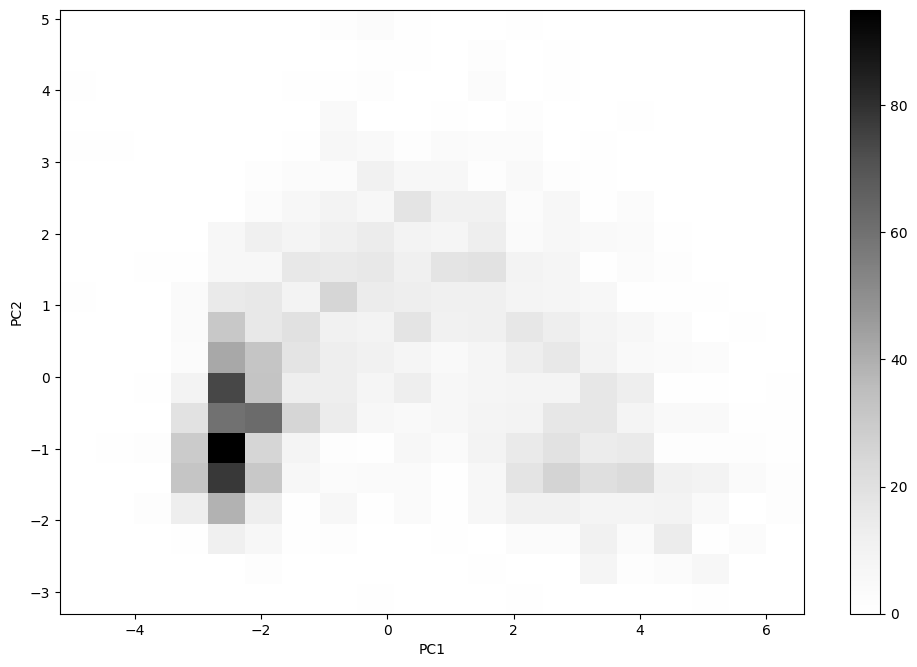

In [11]:

plt.hist2d(first_components[:,0], first_components[:,1], bins=[20, 20], cmap="Greys")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()

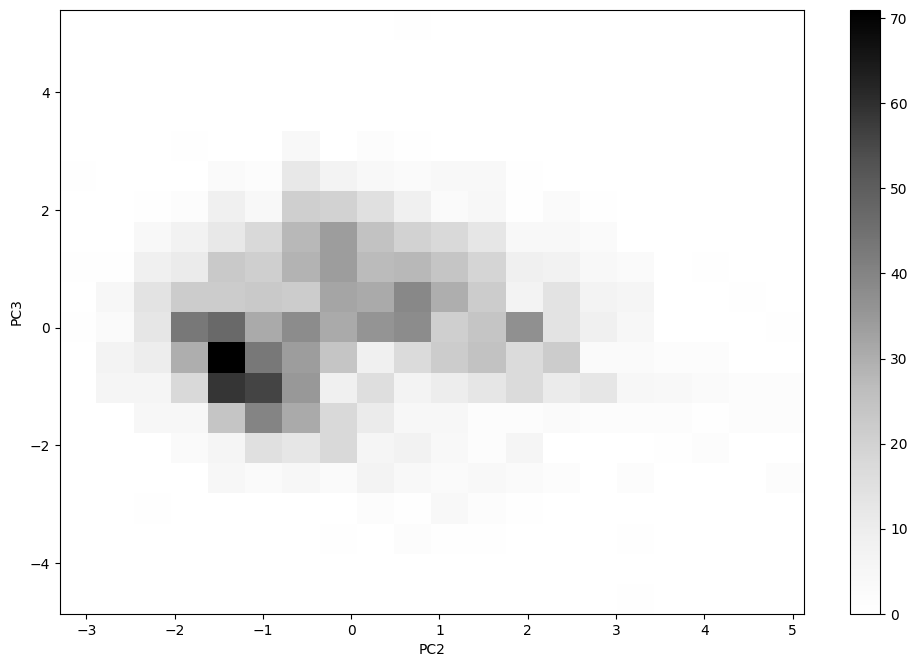

In [12]:
plt.hist2d(first_components[:,1], first_components[:,2], bins=[20, 20], cmap="Greys")
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.colorbar()

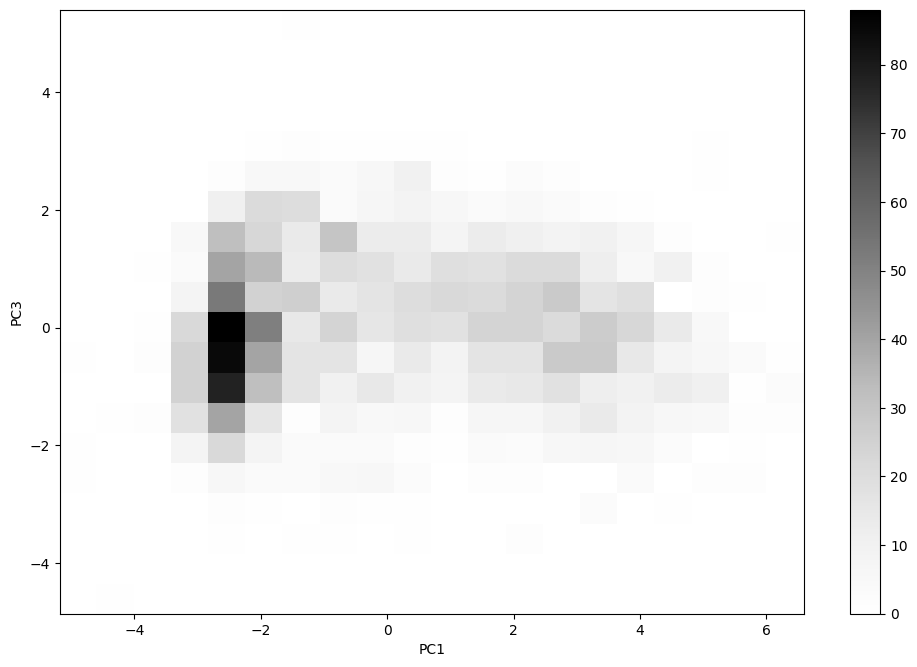

In [13]:
plt.hist2d(first_components[:,0], first_components[:,2], bins=[20, 20], cmap="Greys")
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.colorbar()

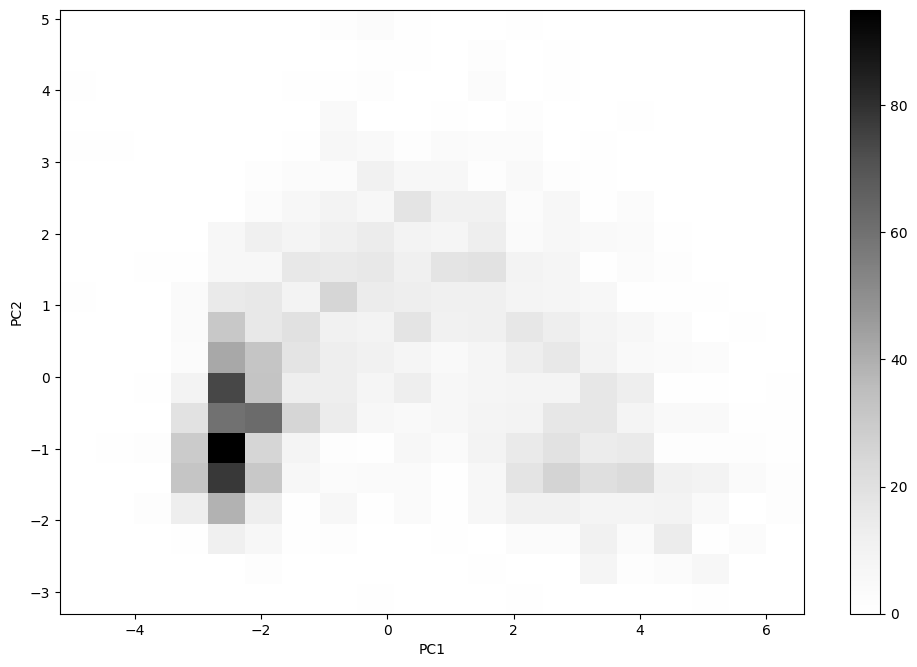

In [14]:
plt.hist2d(first_components[:,0], first_components[:,1], bins=[20, 20], cmap="Greys")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()

This is starting to look better, but let's try to identify the clusters by first quantile transforming each column of the dataset. This means that a value of 0.3 in a column (say income) means that person made mode money than 30% of other customers, but less than 70% of customers. I will then perform PCA on the transformed data and look for clear clusters in the dataset.

In [15]:
#let's take another look at the data, but this time let's make each dimension uniform
#let's do PCA and analyze the data again.
column_names = [c for c in data_nobinary.columns if c not in blacklist]
data_arrays = data_nobinary[column_names].values
data_arrays = data_arrays[np.logical_not(np.any(np.isnan(data_arrays), axis=1))]


from sklearn.preprocessing import QuantileTransformer
#scale the principal components=
def quantile_scale_array(arrays):
    qt = QuantileTransformer()
    qt.fit(arrays)
    arrays = qt.transform(arrays)
    return arrays

data_arrays_quantiled = quantile_scale_array(data_arrays)
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data_arrays_quantiled)
print(pca.explained_variance_ratio_)

[0.43820619 0.13598146 0.09073891 0.05283852 0.05203926 0.04132945
 0.03513956 0.03009958 0.02471254 0.02020477 0.0193139  0.01792326
 0.0145829  0.01017635 0.0073257  0.00521423 0.00417342]


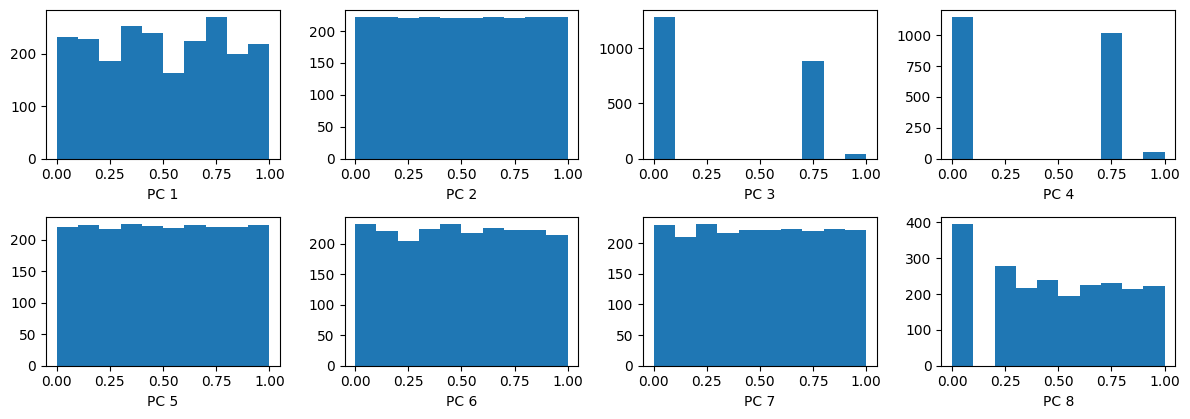

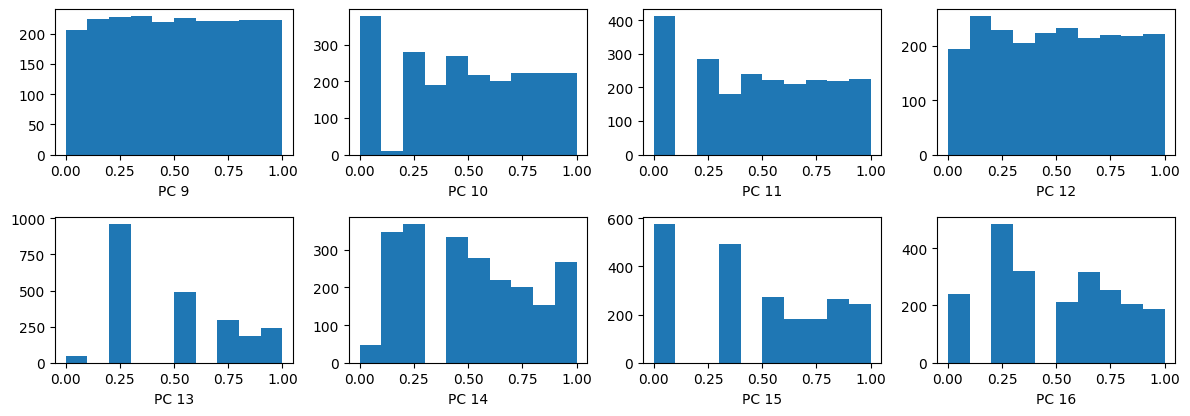

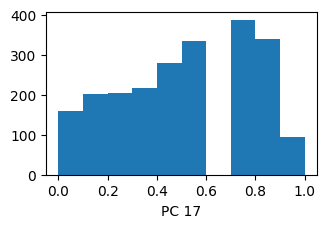

In [16]:
plotted = 0
for i in range(1, data_arrays_quantiled.shape[-1] + 1):
    plotted += 1
    if plotted > 8: 
        plt.show()
        plotted = 1
    plt.subplot(440 + plotted)
    stuff = plt.hist(data_arrays_quantiled[:, i-1])
    plt.tight_layout()
    plt.xlabel("PC {}".format(i))

In [17]:
transformed_arrays = pca.transform(data_arrays_quantiled)

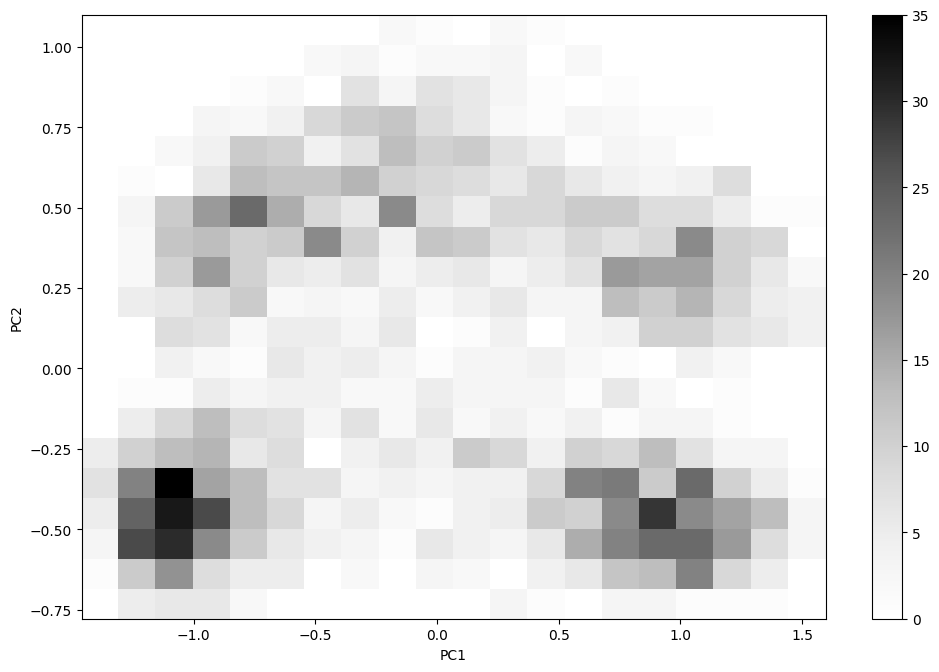

In [18]:
stuff = plt.hist2d(transformed_arrays[:,0], transformed_arrays[:,1], bins=[20, 20], cmap="Greys")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()

Great! It looks like there are four clear clusters of customers. Let's run a k-means algorithm an see if it agrees...

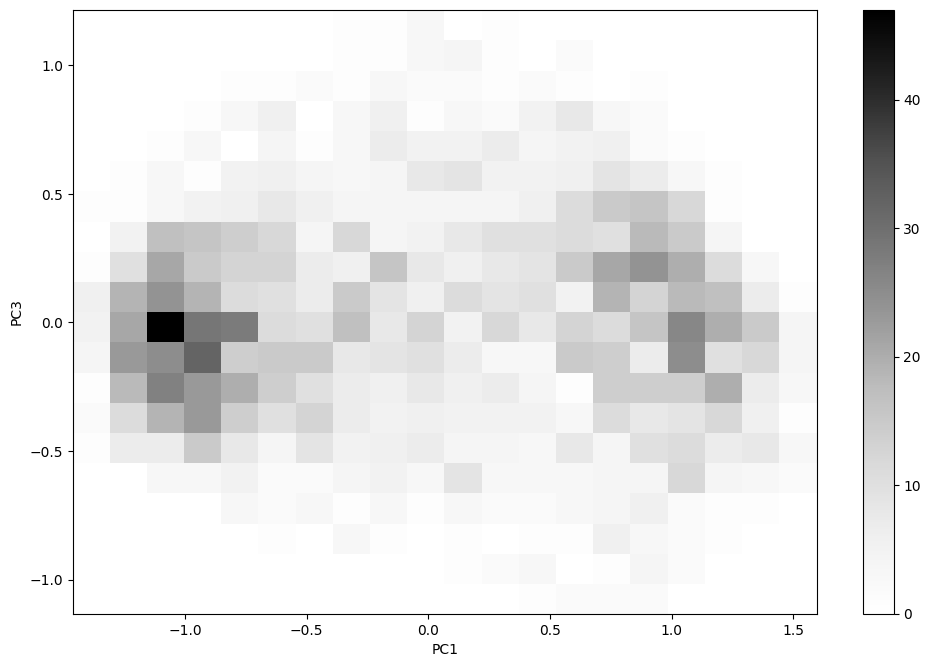

In [19]:
stuff = plt.hist2d(transformed_arrays[:,0], transformed_arrays[:,2], bins=[20, 20], cmap="Greys")
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.colorbar()

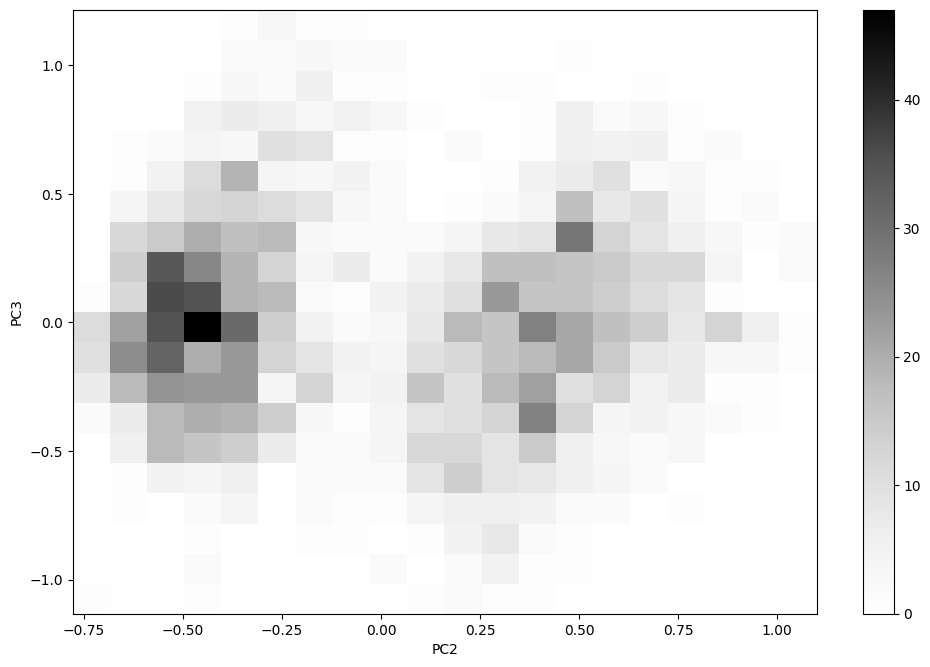

In [20]:
stuff = plt.hist2d(transformed_arrays[:,1], transformed_arrays[:,2], bins=[20, 20], cmap="Greys")
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.colorbar()

In [21]:
#This is great news! it looks like there are ~ four clusters of events present!
#let's try some k-means clustering

from sklearn.cluster import KMeans

clus = KMeans(n_clusters=4)
kmeans = clus.fit(transformed_arrays[:, :3])
pred = clus.predict(transformed_arrays[:, :3])
print(pred)

[1 0 1 ... 1 2 0]


In [22]:
def plot_clusters(transformed_arrays, PC1, PC2, pred):

    stuff = plt.hist2d(transformed_arrays[:,PC1], transformed_arrays[:,PC2], bins=[20, 20], cmap="Greys")
    plt.xlabel("PC{}".format(PC1+1))
    plt.ylabel("PC{}".format(PC2+1))
    plt.colorbar()
    plt.show()

    for i in range(1, 5):
        plt.subplot(220+i)
        bins_x = np.linspace(min(transformed_arrays[:, PC1]), max(transformed_arrays[:, PC1]), 20)
        bins_y = np.linspace(min(transformed_arrays[:, PC2]), max(transformed_arrays[:, PC2]), 20)
        in_class = transformed_arrays[:, : 3][pred == i - 1]
        stuff = plt.hist2d(in_class[:,PC1], in_class[:,PC2], bins=[bins_x, bins_y], cmap="Greys")
        plt.xlabel("PC{}".format(PC1 + 1))
        plt.ylabel("PC{}".format(PC2 + 1))
        plt.title("Cluster {}".format(i))
        plt.tight_layout()
        plt.colorbar()
    

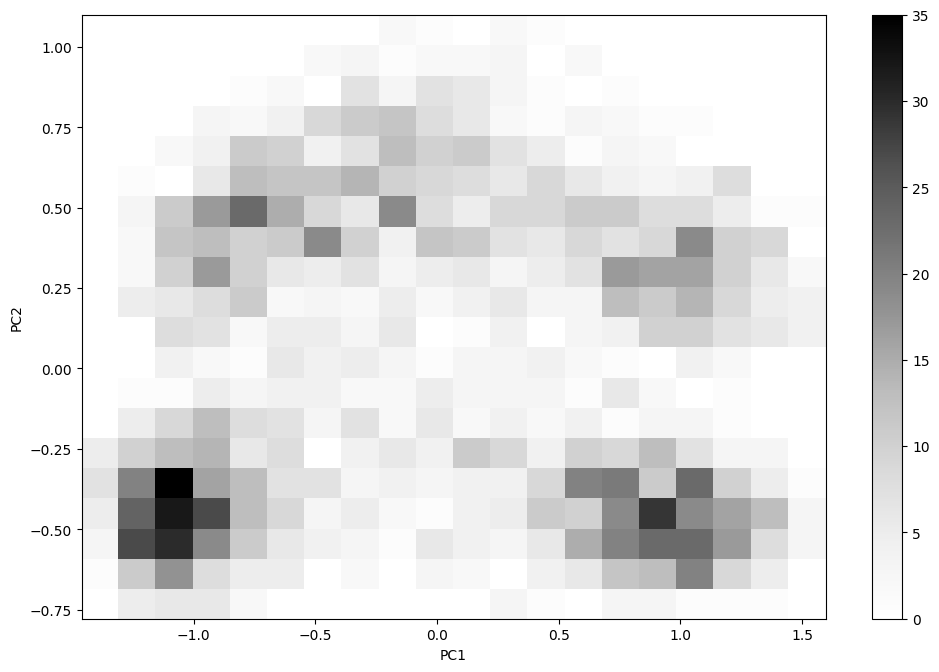

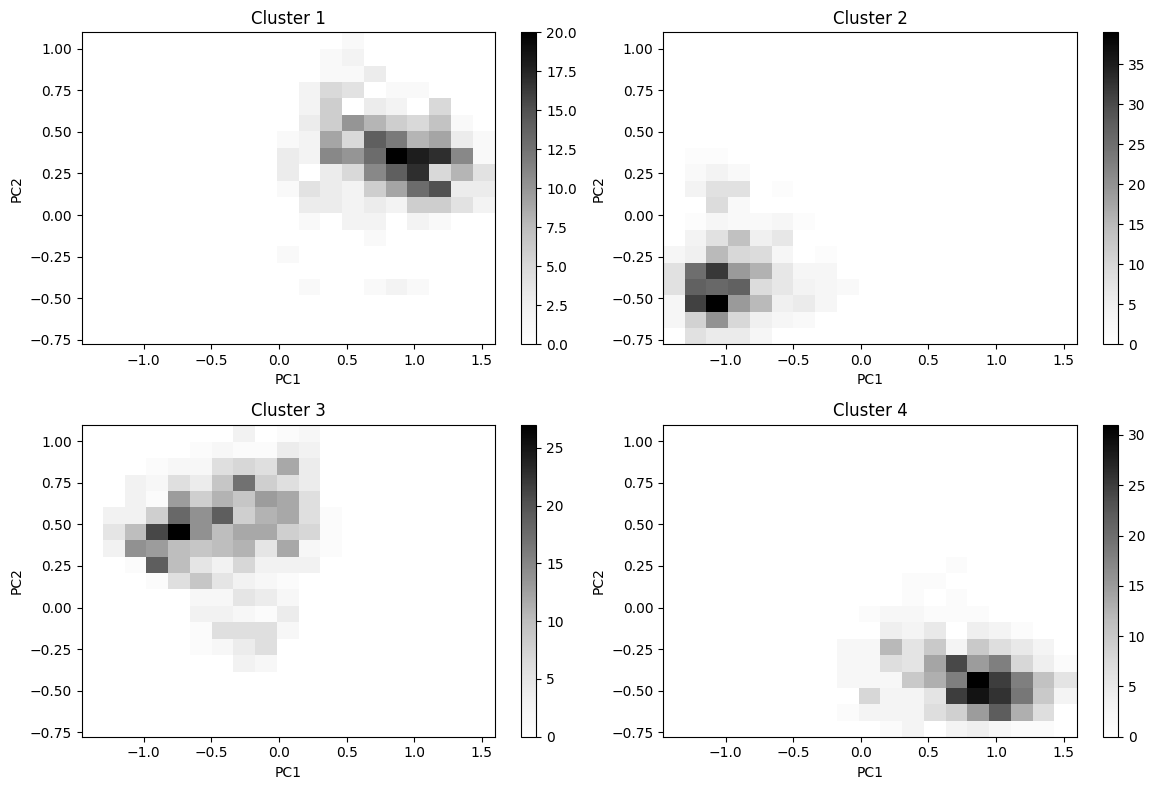

In [23]:
plot_clusters(transformed_arrays, 0, 1, pred)

The clustering algorithm agrees that there were four groups of customers! great.

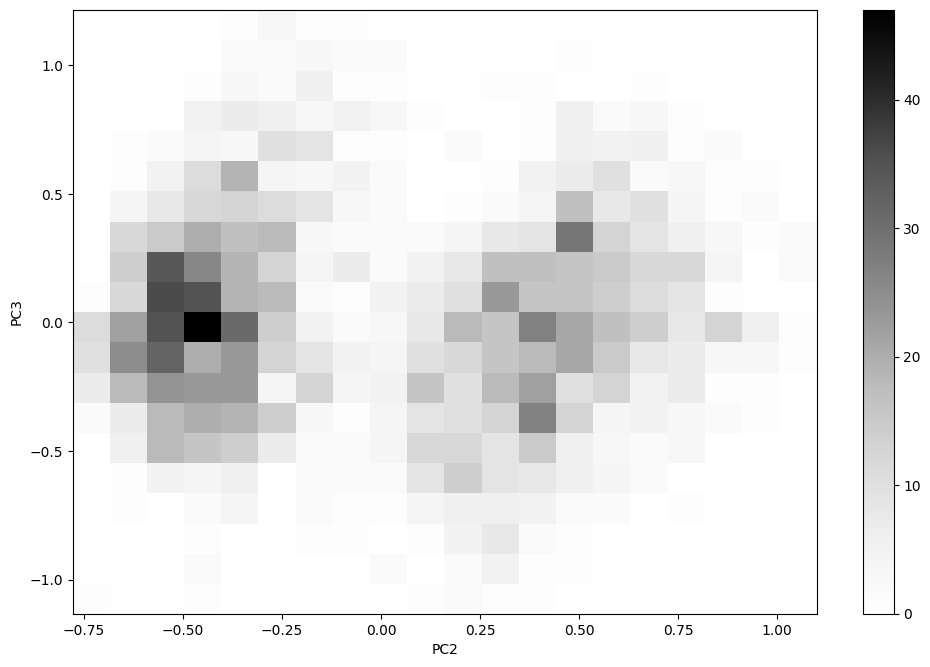

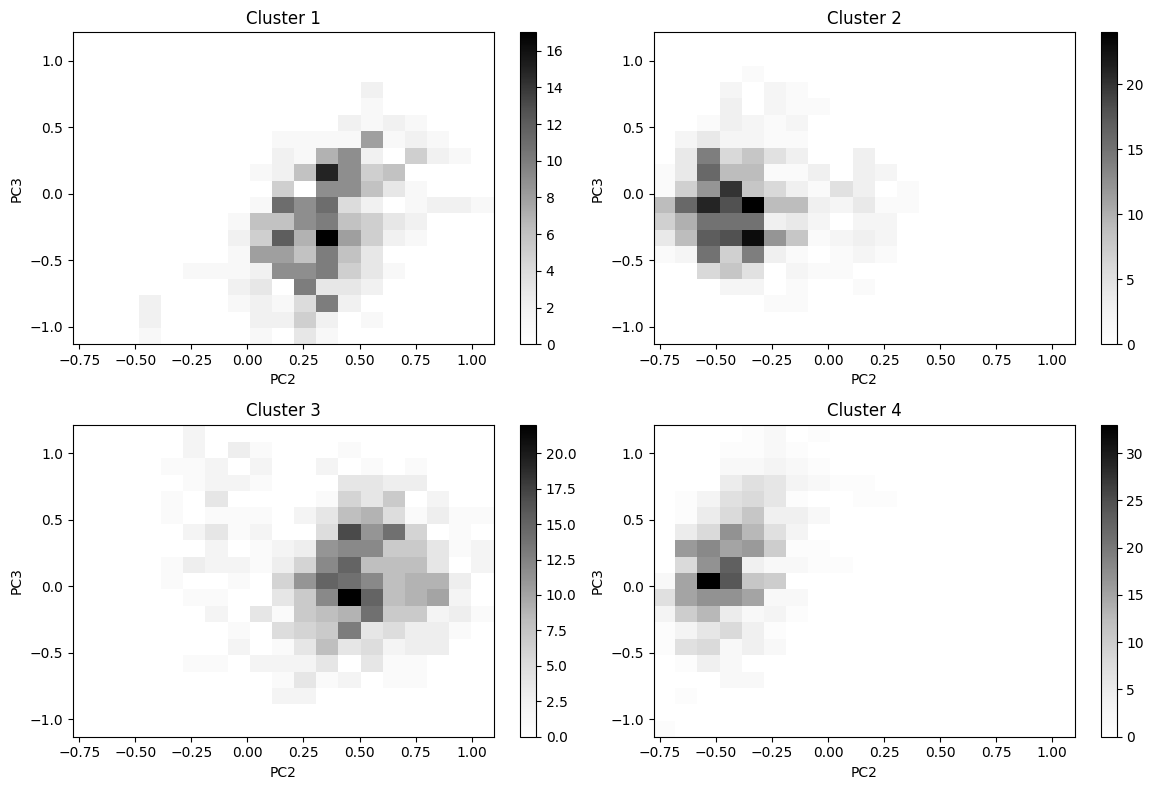

In [24]:
plot_clusters(transformed_arrays, 1, 2, pred)

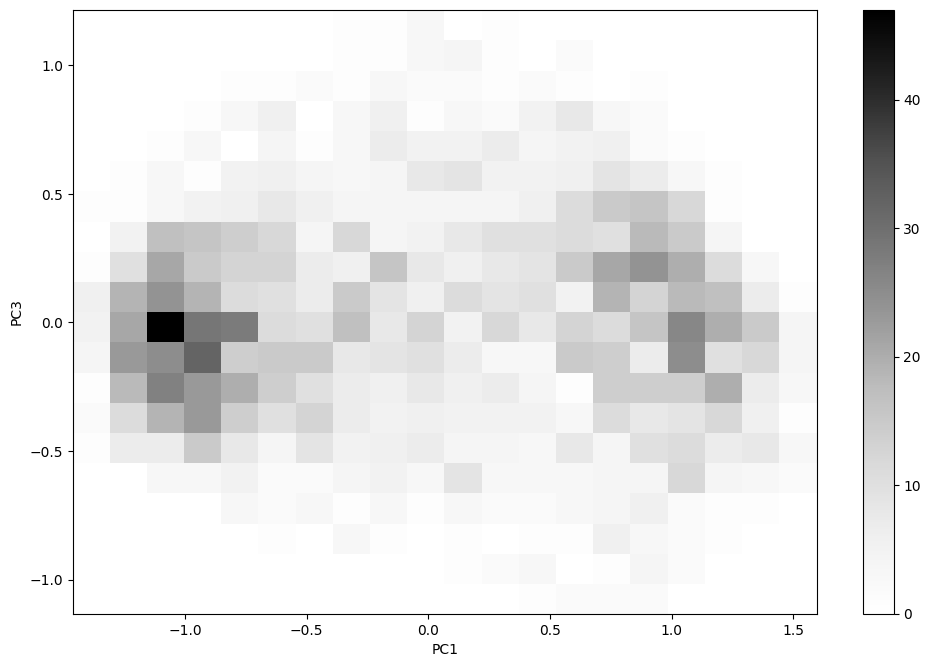

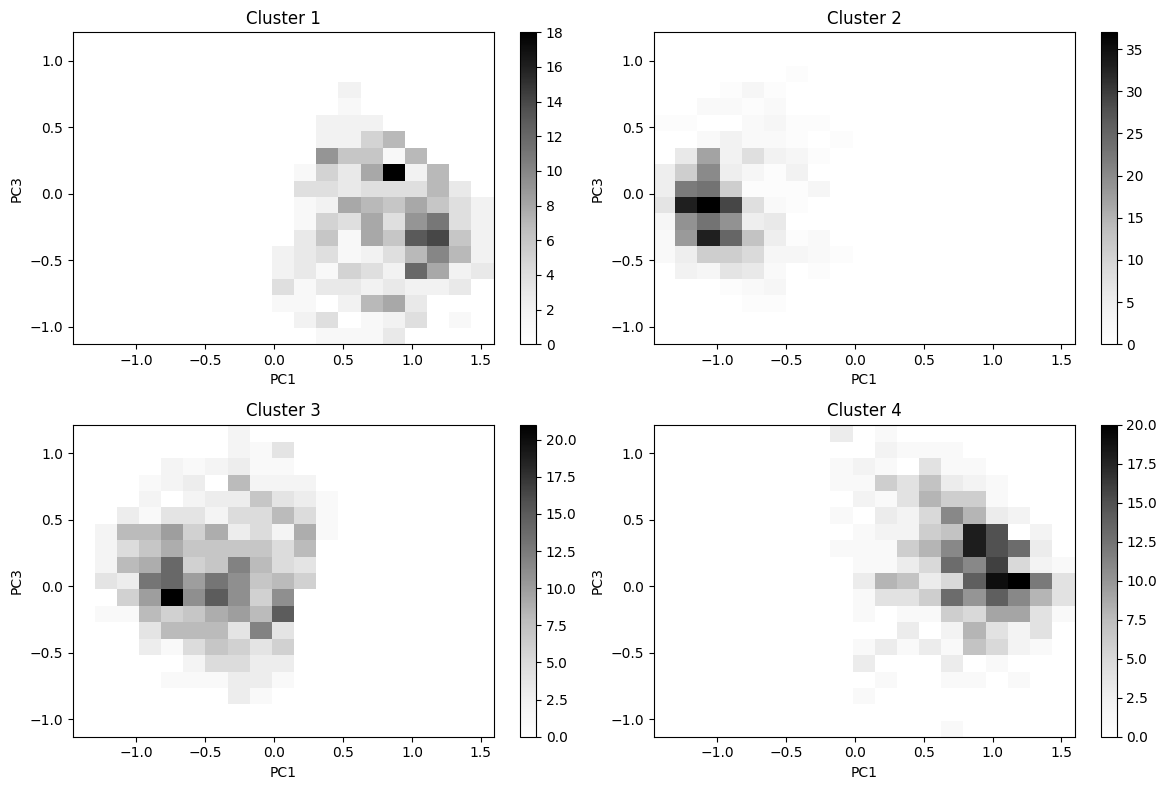

In [25]:
plot_clusters(transformed_arrays, 0, 2, pred)

Let's try to summarize the clear characteristics of the four classes

In [26]:
def get_column_index(c_name, column_names):
    for i, c in enumerate(column_names):
        if c_name == c: break
    if c_name not in column_names: raise ValueError()
    return i

def make_plots(c_name, column_index, data_arrays, pred, quantiled = False):
    print("Plotting {}".format(c_name))
    print(data_arrays[:, column_index].dtype)

    for j in range(min(pred), max(pred) + 1):
        plt.subplot(220+j +1)
        bins = np.linspace(min(data_arrays[:, column_index]), max(data_arrays[:, column_index]), 20)
        if np.all(bins[0] == bins): bins = np.linspace(bins[0]/2.0, 3.0 * bins[0]/2.0, 20)
        if ("num" in c_name or "Num" in c_name[:4]) and not quantiled:
            bins = np.arange(int(min(data_arrays[:, column_index])), int(max(data_arrays[:, column_index])) + 1) - 0.5
        if (c_name == "Year_Birth" or c_name == "Dt_Customer") and not quantiled:
            plt.hist(data_arrays[:, column_index][pred==j].astype("datetime64[ns]"))
        else: plt.hist(data_arrays[:, column_index][pred==j], bins = bins)
        if not quantiled: plt.xlabel("{}".format(c_name))
        else: plt.xlabel("Quantile of {}".format(c_name))
        plt.title("Class {}".format(j + 1))
        plt.tight_layout()
    plt.show()

In [27]:
# the first thing is to note the differences in income.
def analyze_column(column_name, column_names, data_arrays, data_arrays_quantiled, pred, descriptors):
    i = get_column_index(column_name, column_names)
    income_trimmed = (data_arrays_quantiled[:, i] < 0.99) & (0.01 < data_arrays_quantiled[:,i]) # cut away the outliers
    if np.sum(income_trimmed * 1) > 0 and "home" not in column_name: make_plots(column_name, i, data_arrays[income_trimmed], pred[income_trimmed])
    else: make_plots(column_name, i, data_arrays, pred)
    if "Num" not in column_name[:4] and "num" not in column_name[:4]: make_plots(column_name, i, data_arrays_quantiled, pred, quantiled = True)
    averages = []
    for cat in [0, 1, 2, 3]:
        if not (column_name == "Year_Birth" or column_name == "Dt_Customer"): 
            average = np.average(data_arrays[:, i][income_trimmed][pred[income_trimmed] == cat])

        else: 
            average = np.array([np.average(data_arrays[:, i][income_trimmed][pred[income_trimmed] == cat])]).astype("datetime64[ns]").astype("datetime64[Y]")
            average = average[0]
        print("class {} ".format(cat + 1) + descriptors[column_name].format(average))
        averages.append(average)
    return averages
        

['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
Plotting Year_Birth
float64


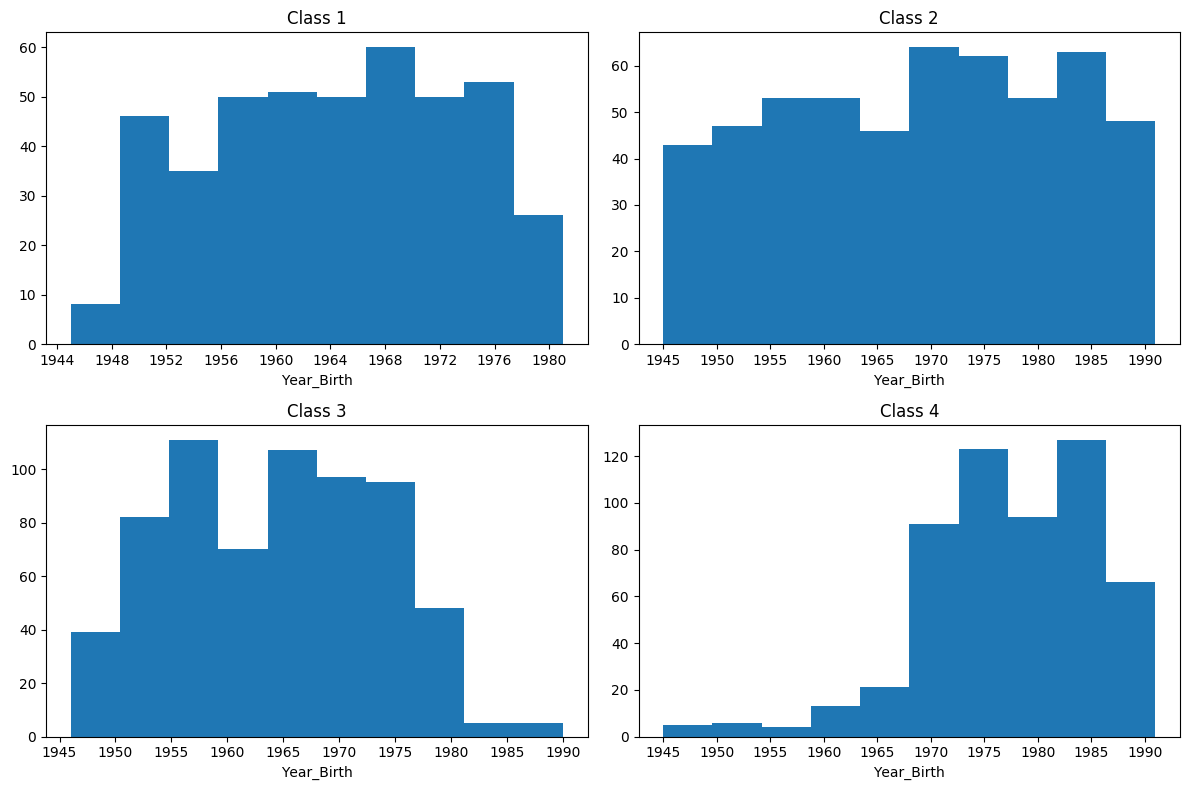

Plotting Year_Birth
float64


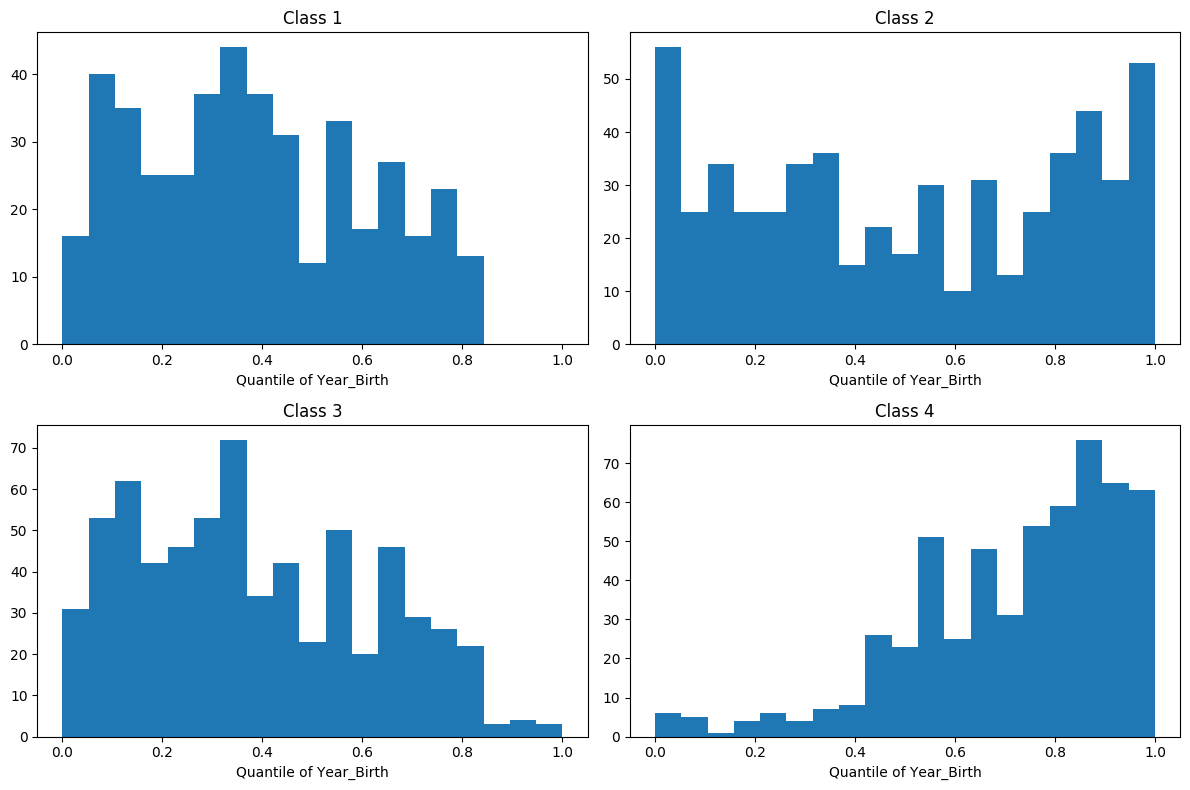

class 1 was born in 1964, on average
class 2 was born in 1968, on average
class 3 was born in 1964, on average
class 4 was born in 1977, on average
Plotting Income
float64


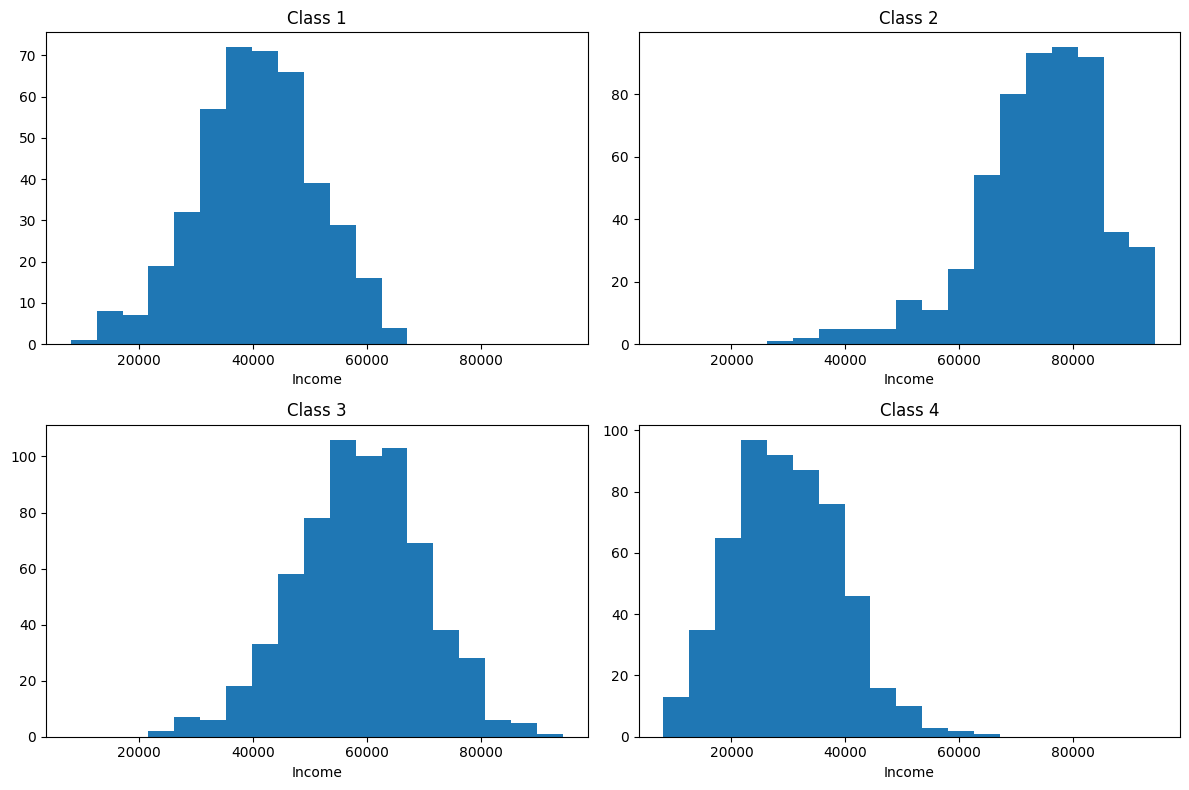

Plotting Income
float64


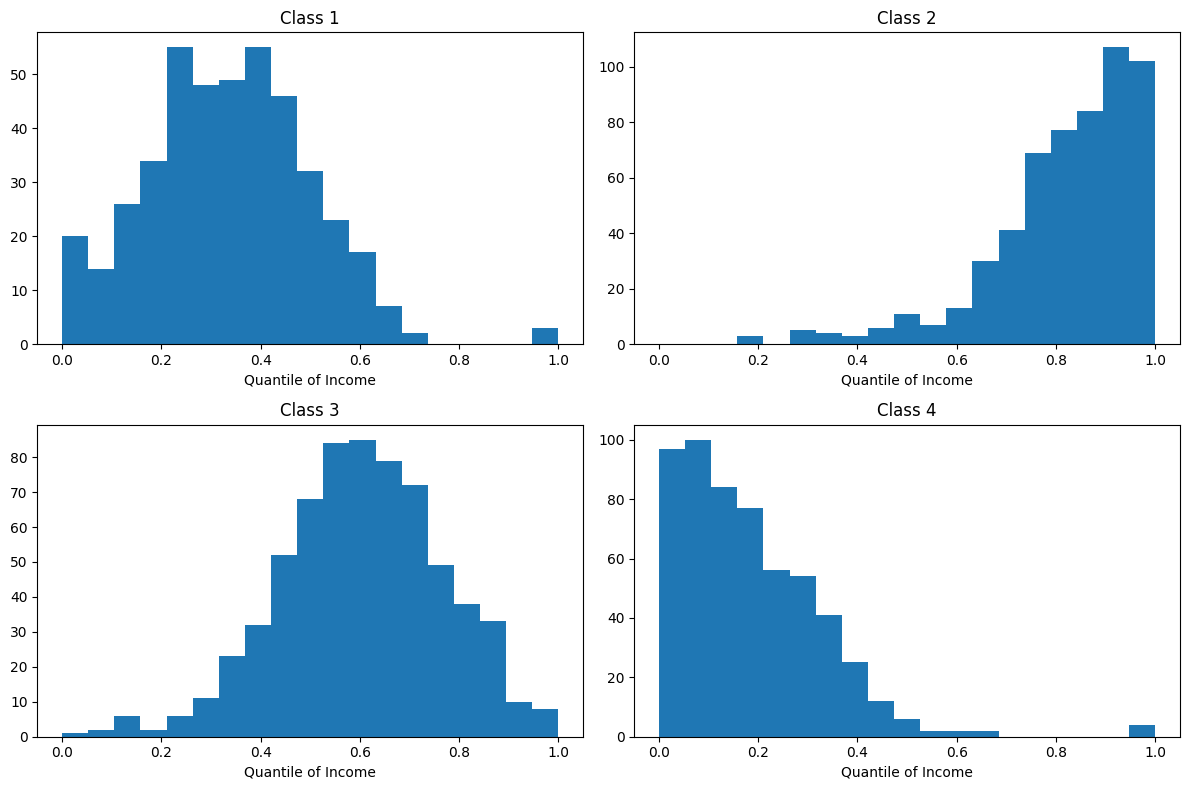

class 1 earned $40588, on average
class 2 earned $73956, on average
class 3 earned $58705, on average
class 4 earned $29711, on average
Plotting Kidhome
float64


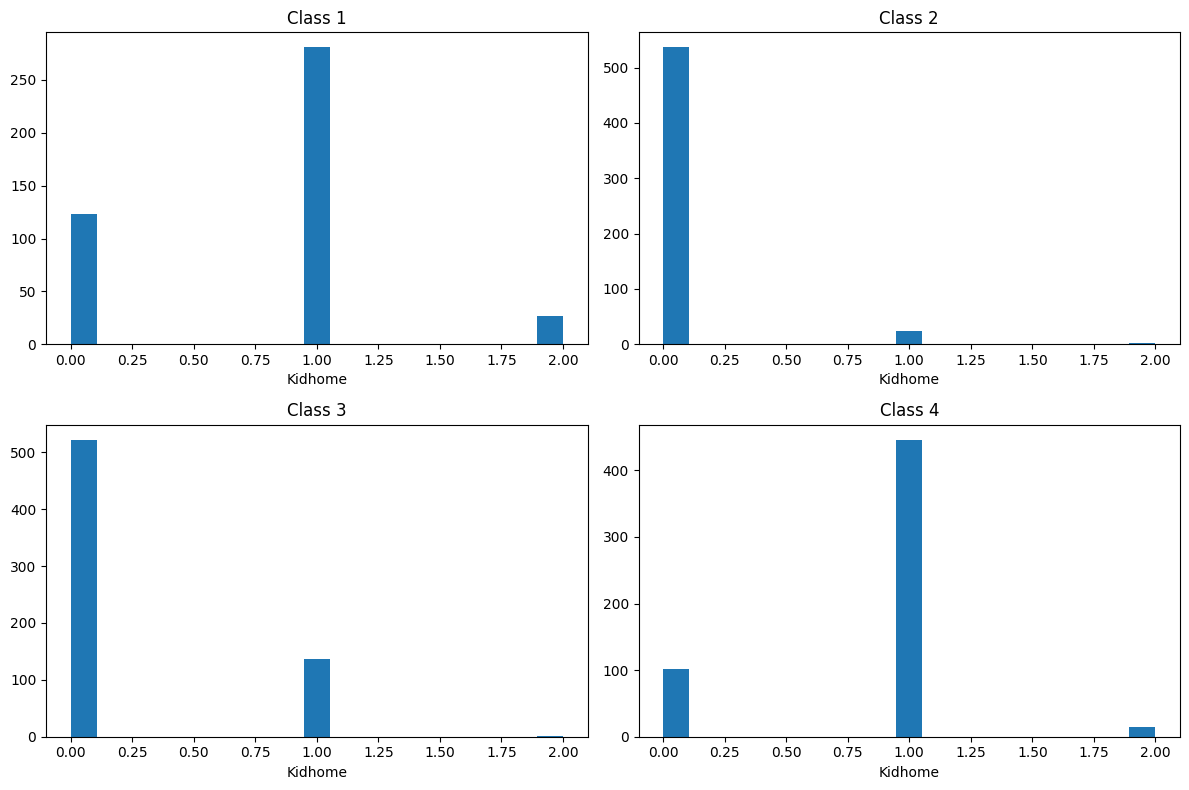

Plotting Kidhome
float64


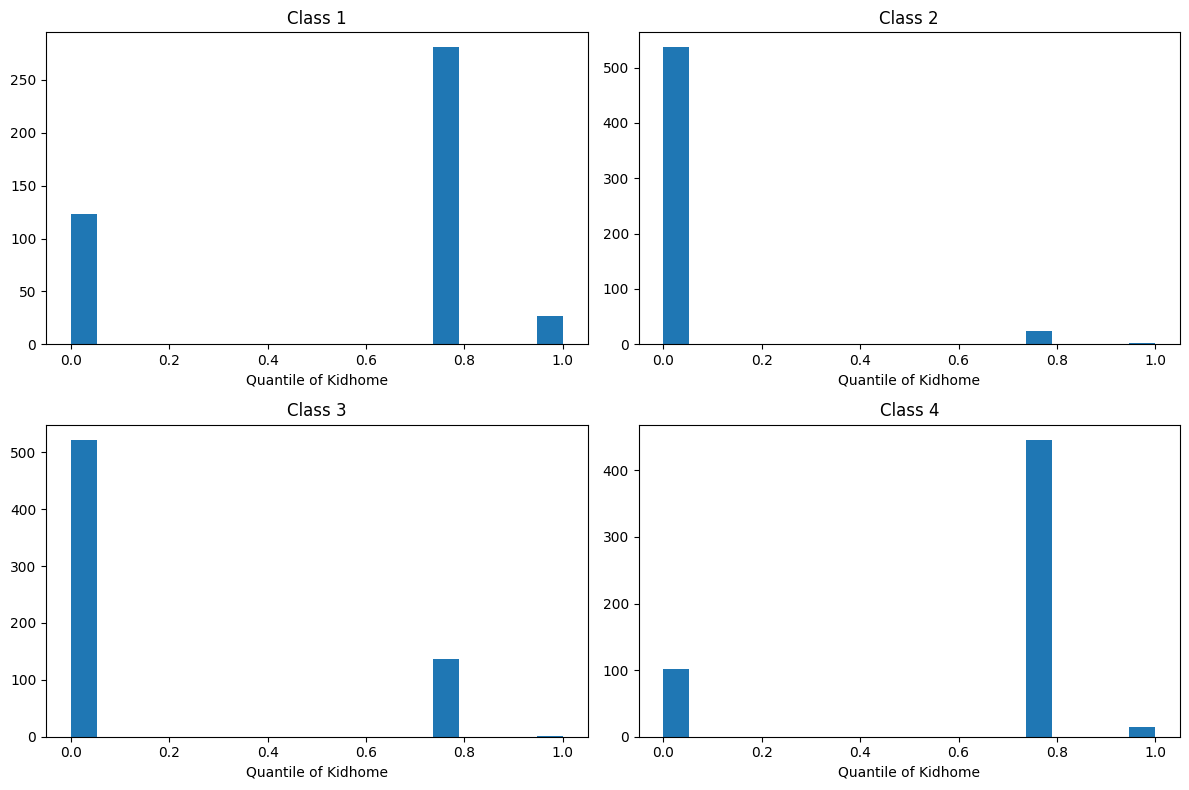

class 1 had 1 kids, on average
class 2 had 1 kids, on average
class 3 had 1 kids, on average
class 4 had 1 kids, on average
Plotting Teenhome
float64


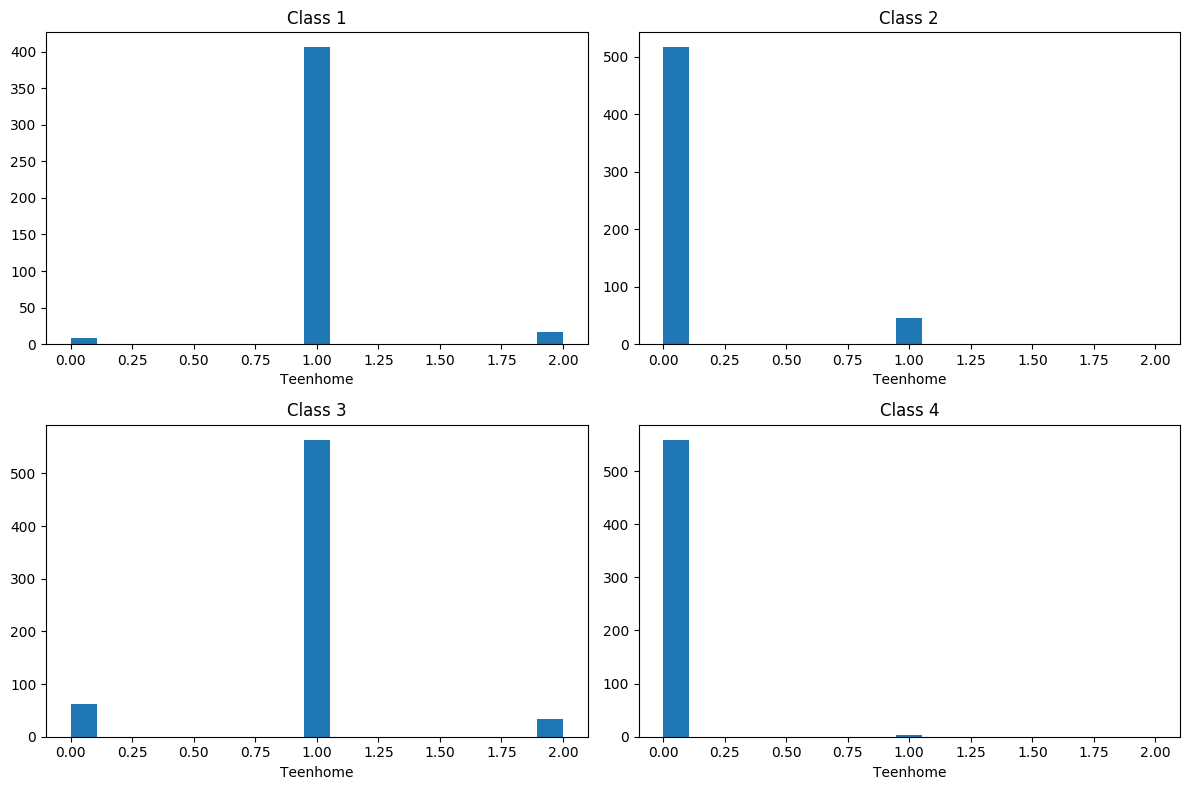

Plotting Teenhome
float64


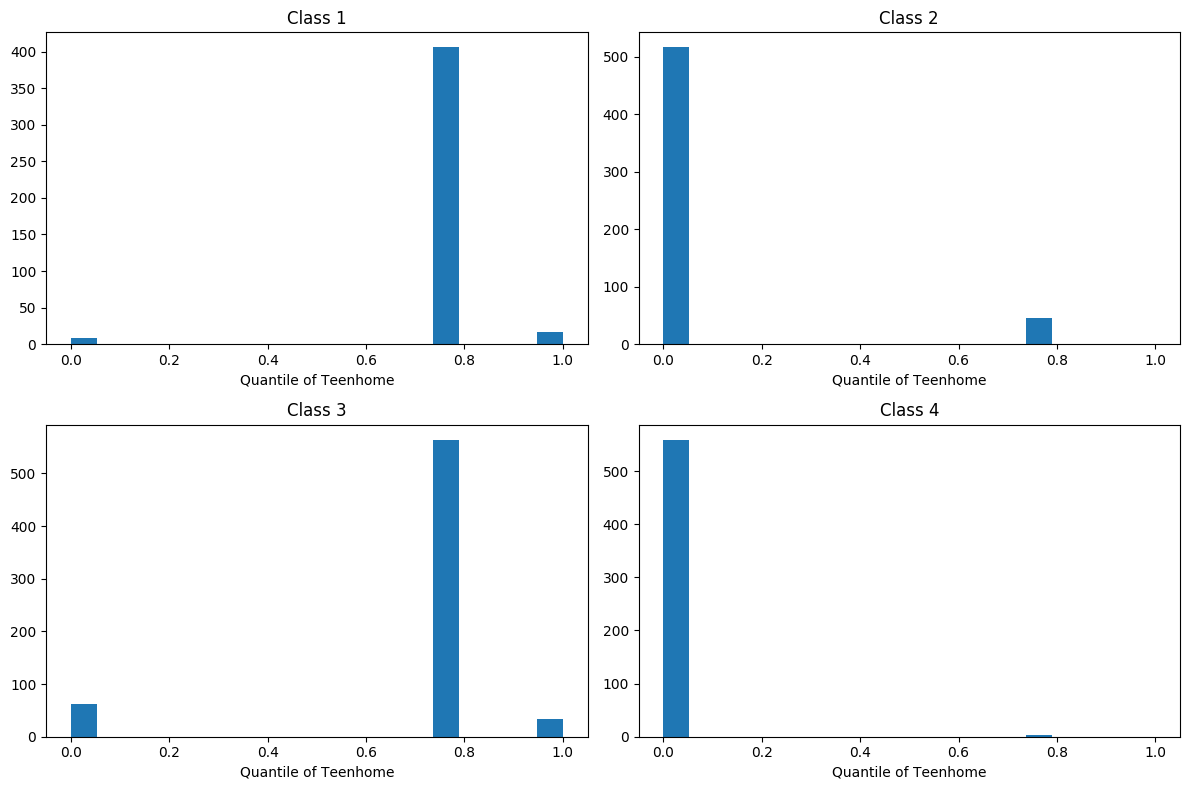

class 1 had 1 teens, on average
class 2 had 1 teens, on average
class 3 had 1 teens, on average
class 4 had 1 teens, on average
Plotting Dt_Customer
float64


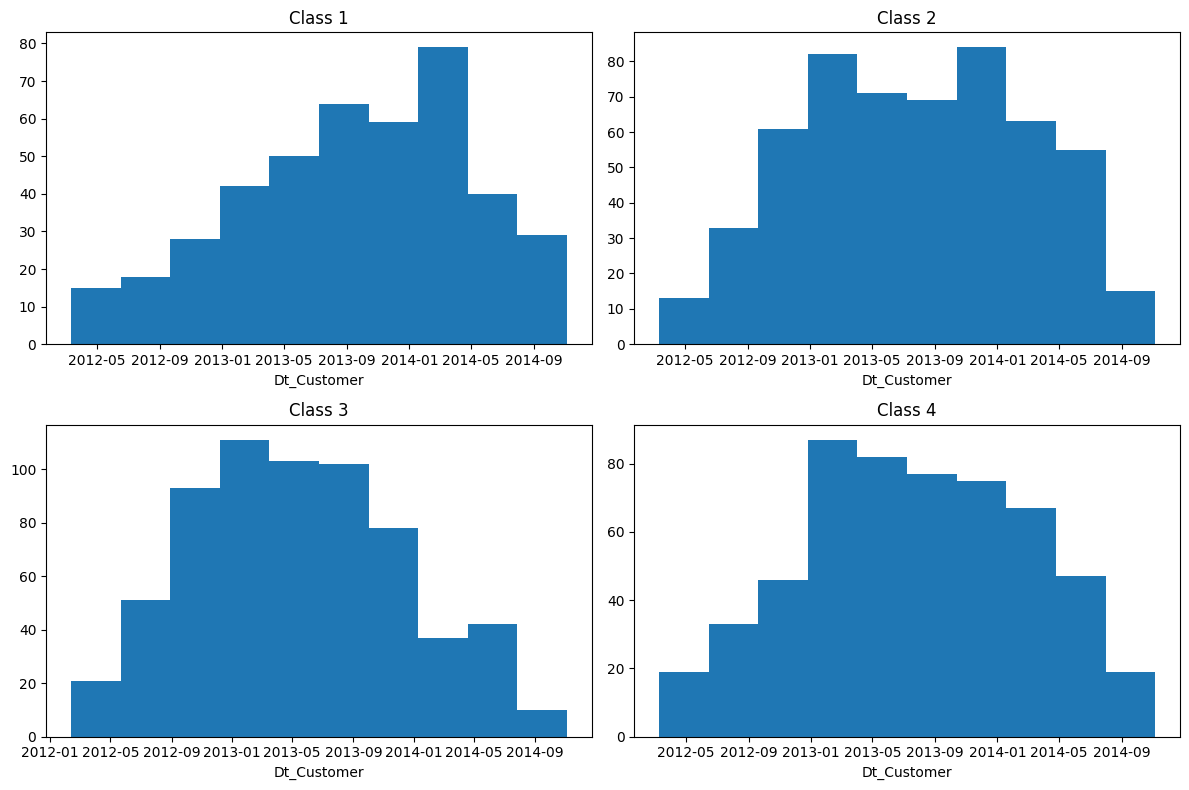

Plotting Dt_Customer
float64


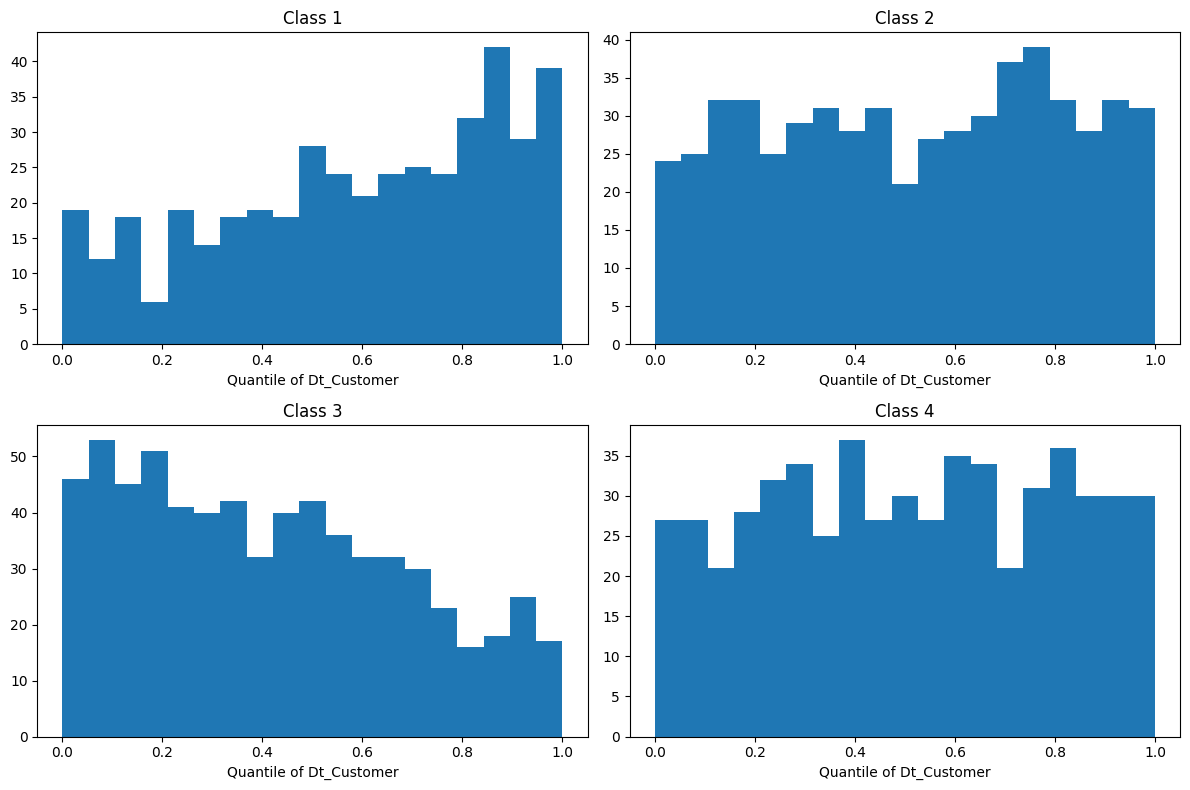

class 1 enrolled in 2013, on average
class 2 enrolled in 2013, on average
class 3 enrolled in 2013, on average
class 4 enrolled in 2013, on average
Plotting Recency
float64


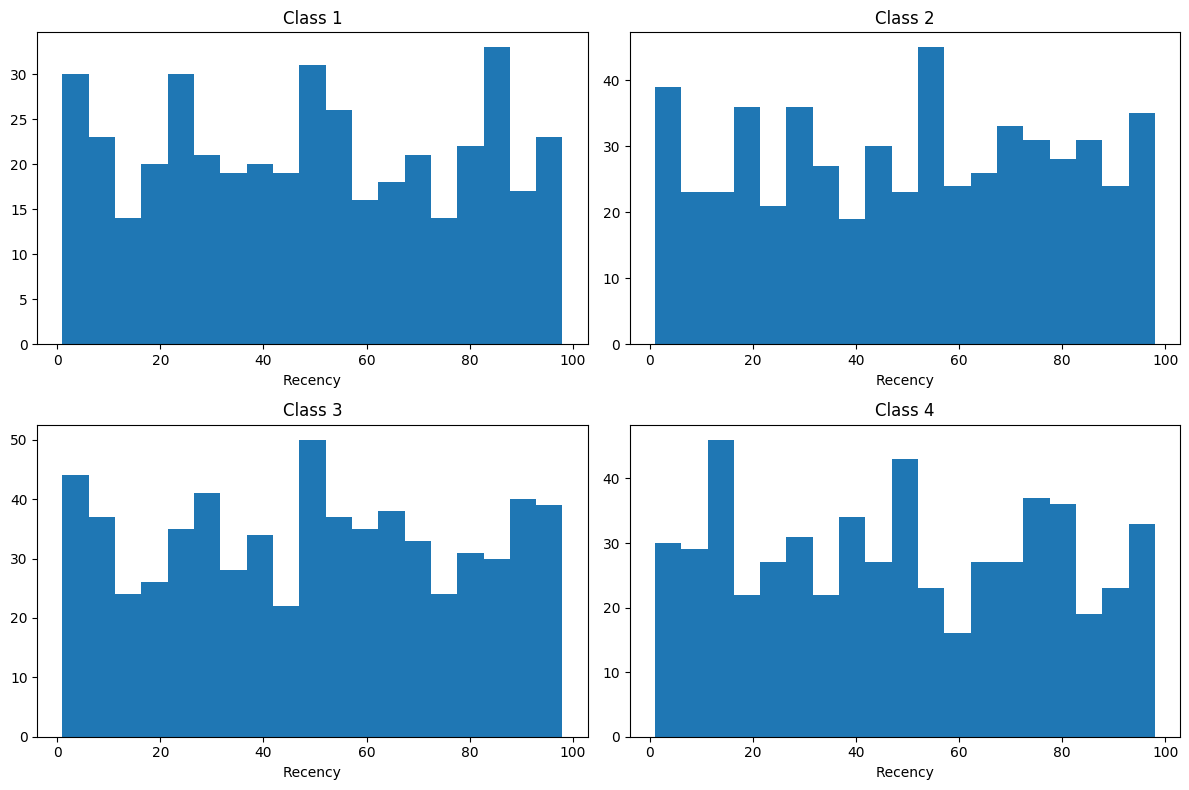

Plotting Recency
float64


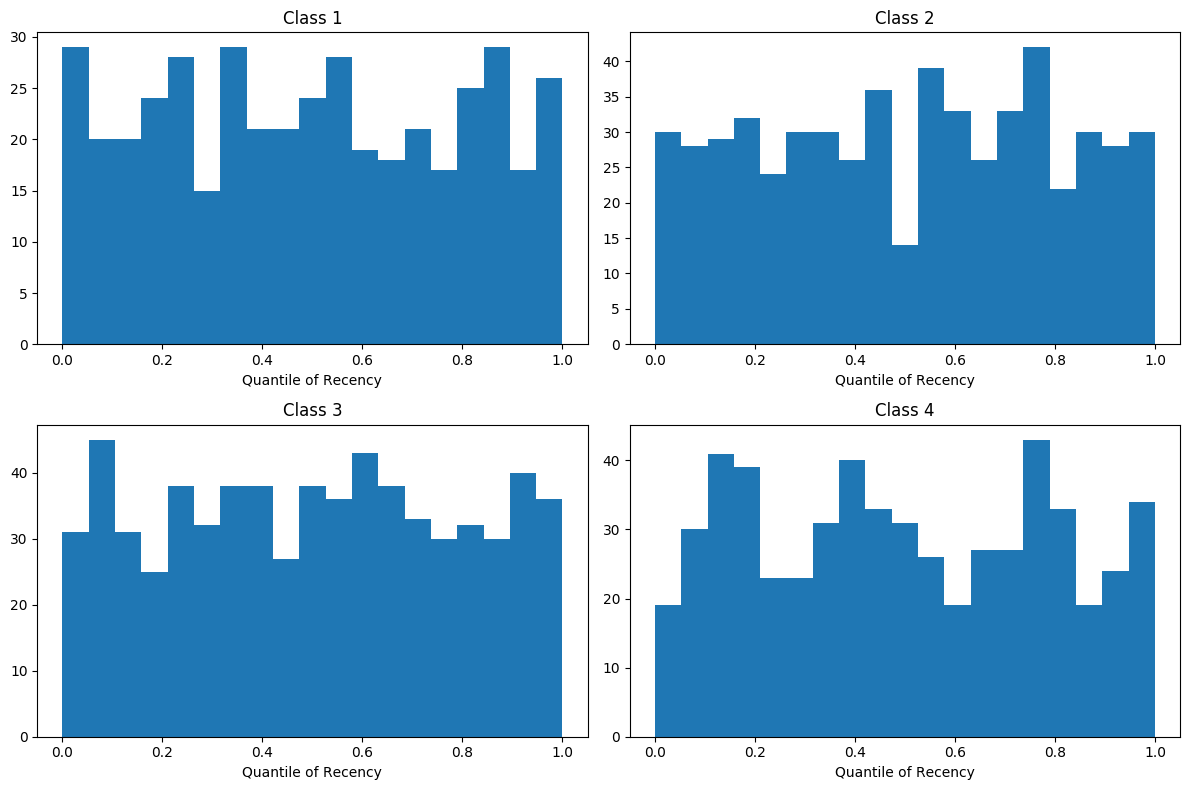

class 1 last purchased 49 days ago, on average
class 2 last purchased 50 days ago, on average
class 3 last purchased 50 days ago, on average
class 4 last purchased 49 days ago, on average
Plotting MntWines
float64


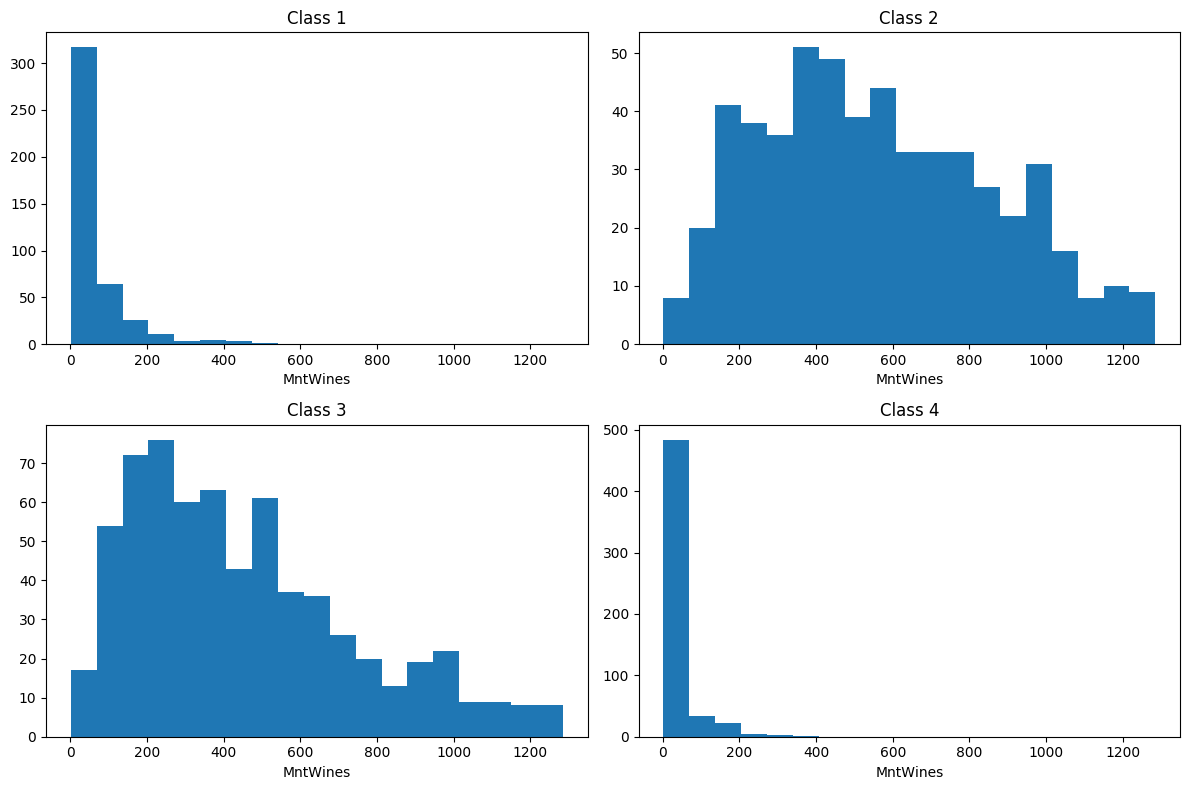

Plotting MntWines
float64


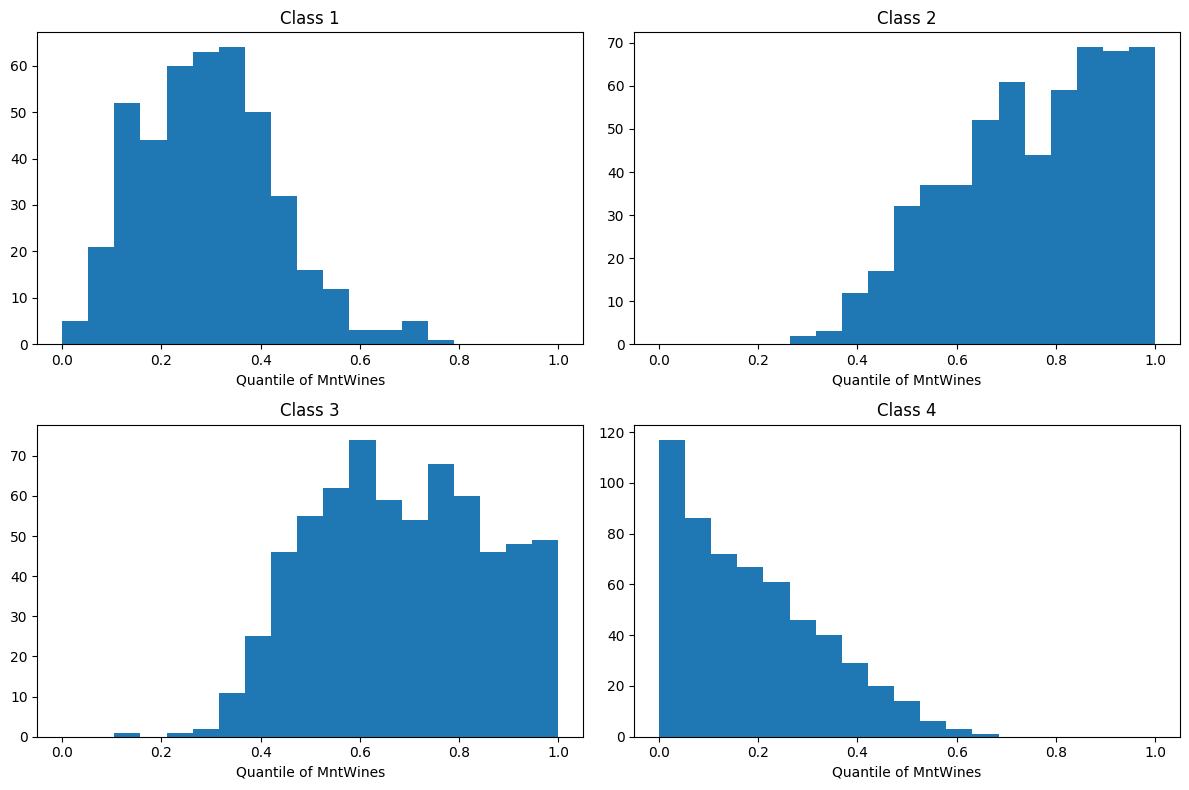

class 1 spent $60 on wines, on average
class 2 spent $561 on wines, on average
class 3 spent $453 on wines, on average
class 4 spent $31 on wines, on average
Plotting MntFruits
float64


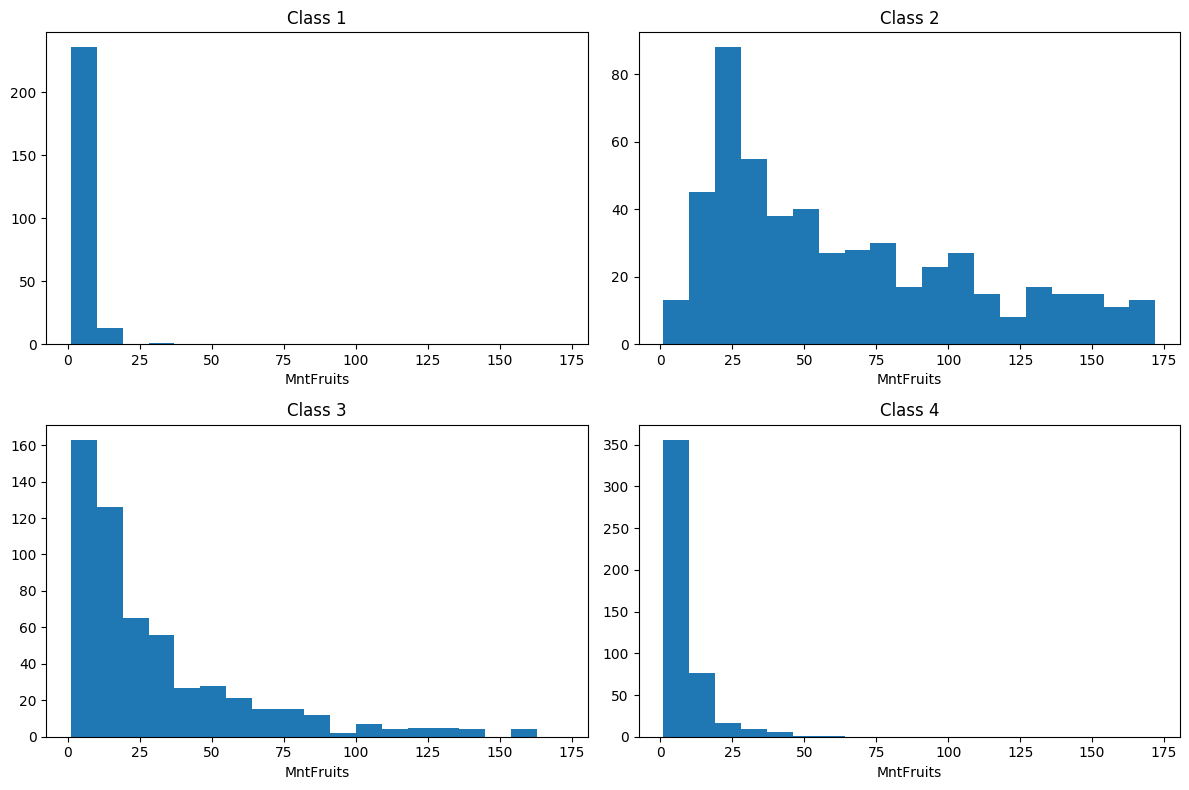

Plotting MntFruits
float64


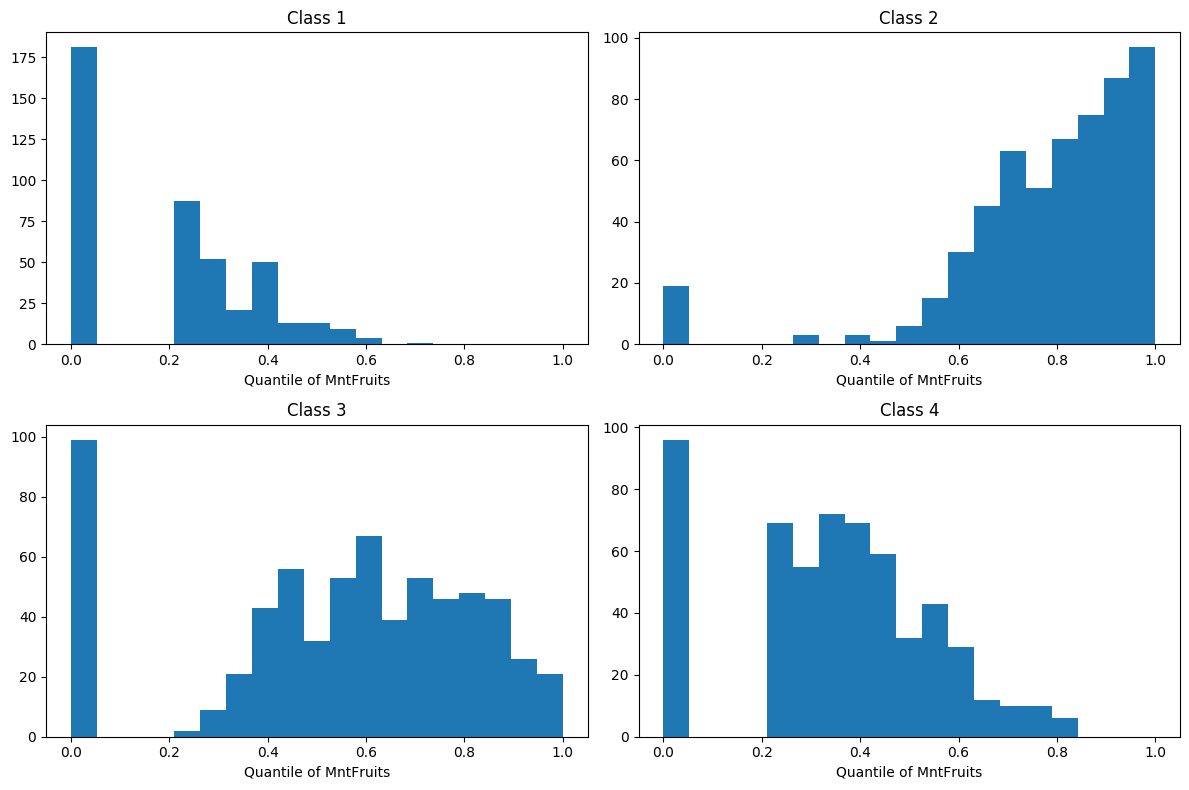

class 1 spent $3 on fruits, on average
class 2 spent $64 on fruits, on average
class 3 spent $30 on fruits, on average
class 4 spent $7 on fruits, on average
Plotting MntMeatProducts
float64


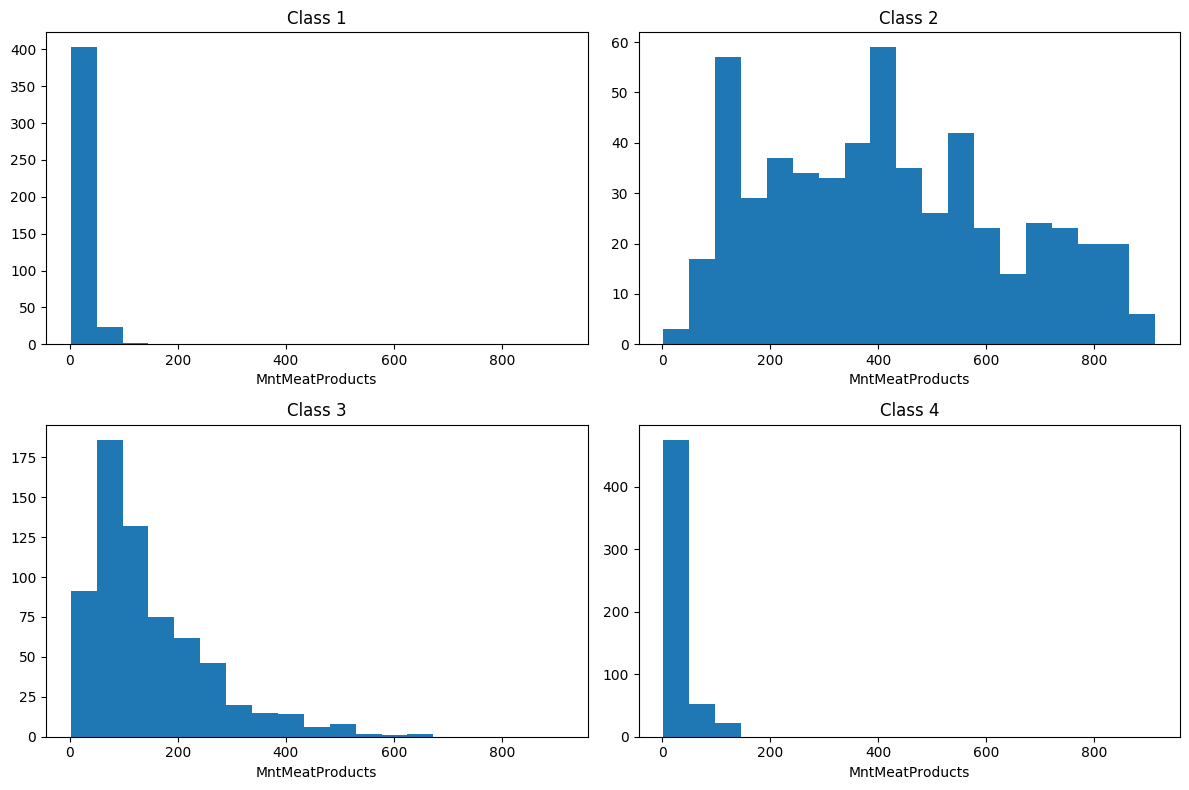

Plotting MntMeatProducts
float64


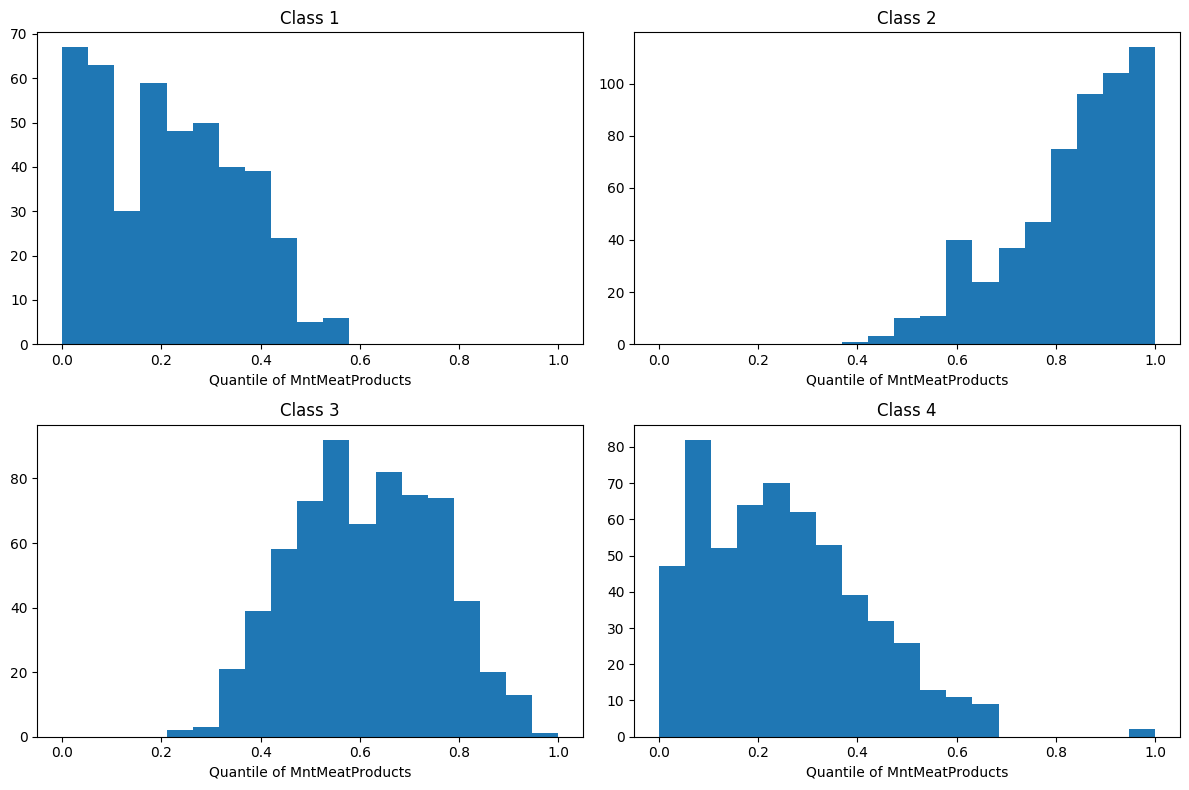

class 1 spent $18 on meats, on average
class 2 spent $417 on meats, on average
class 3 spent $149 on meats, on average
class 4 spent $24 on meats, on average
Plotting MntFishProducts
float64


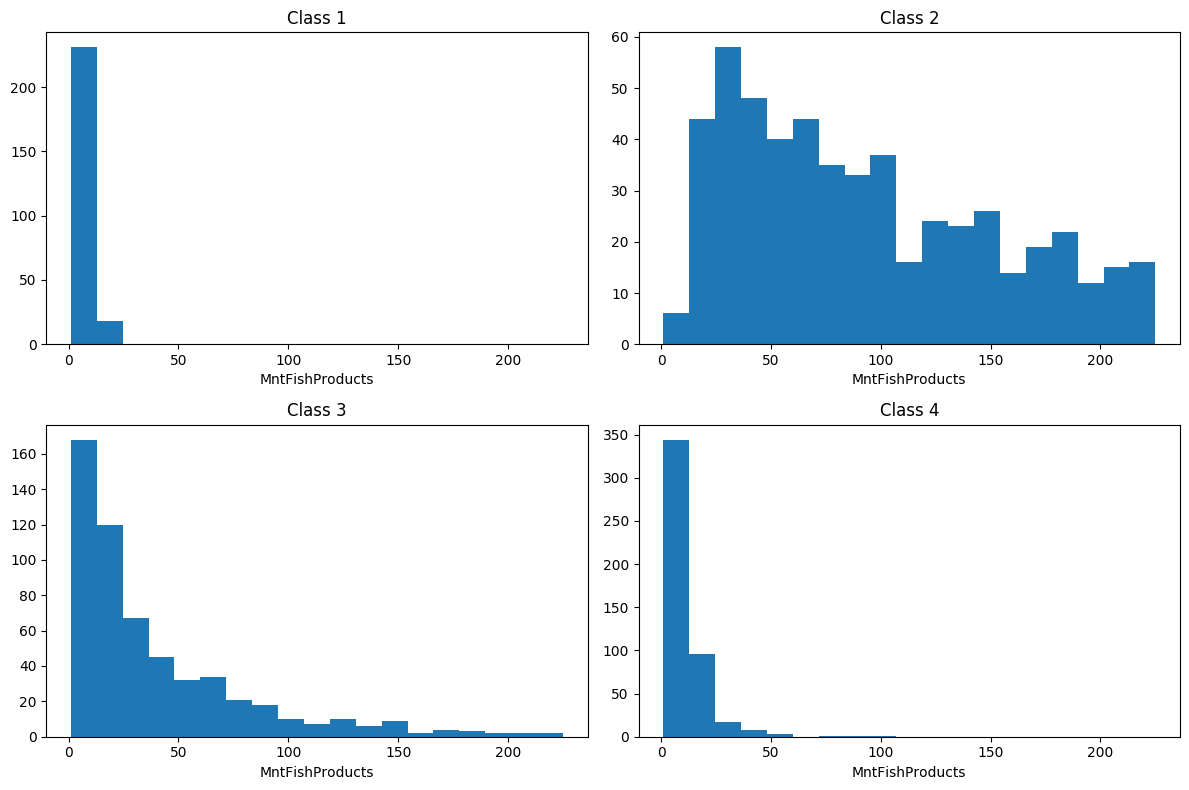

Plotting MntFishProducts
float64


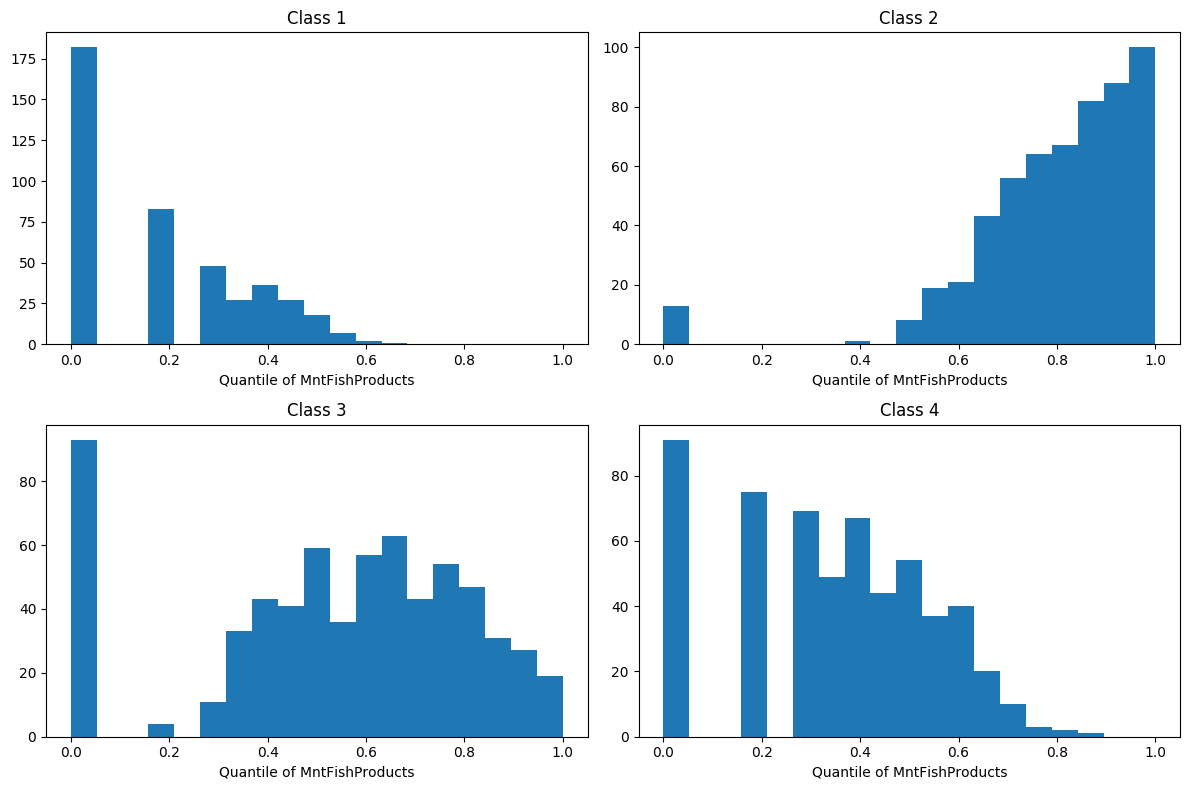

class 1 spent $5 on fish, on average
class 2 spent $93 on fish, on average
class 3 spent $40 on fish, on average
class 4 spent $10 on fish, on average
Plotting MntSweetProducts
float64


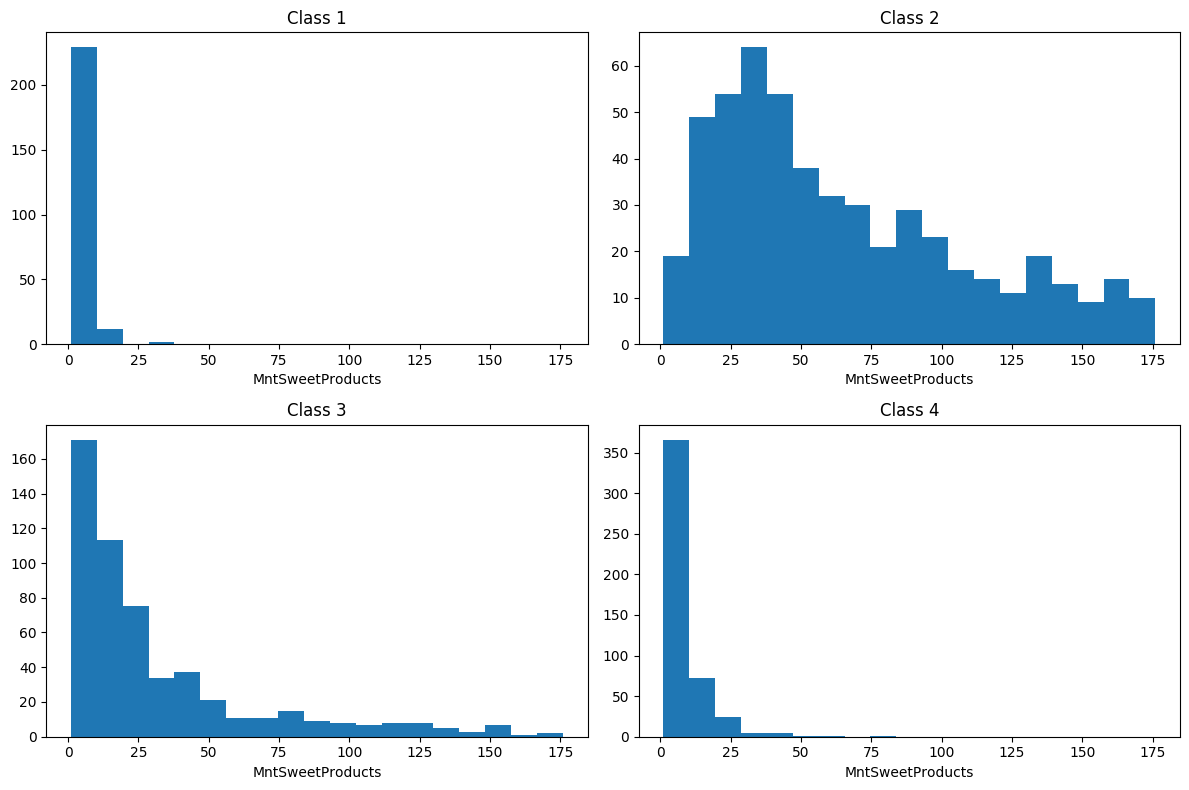

Plotting MntSweetProducts
float64


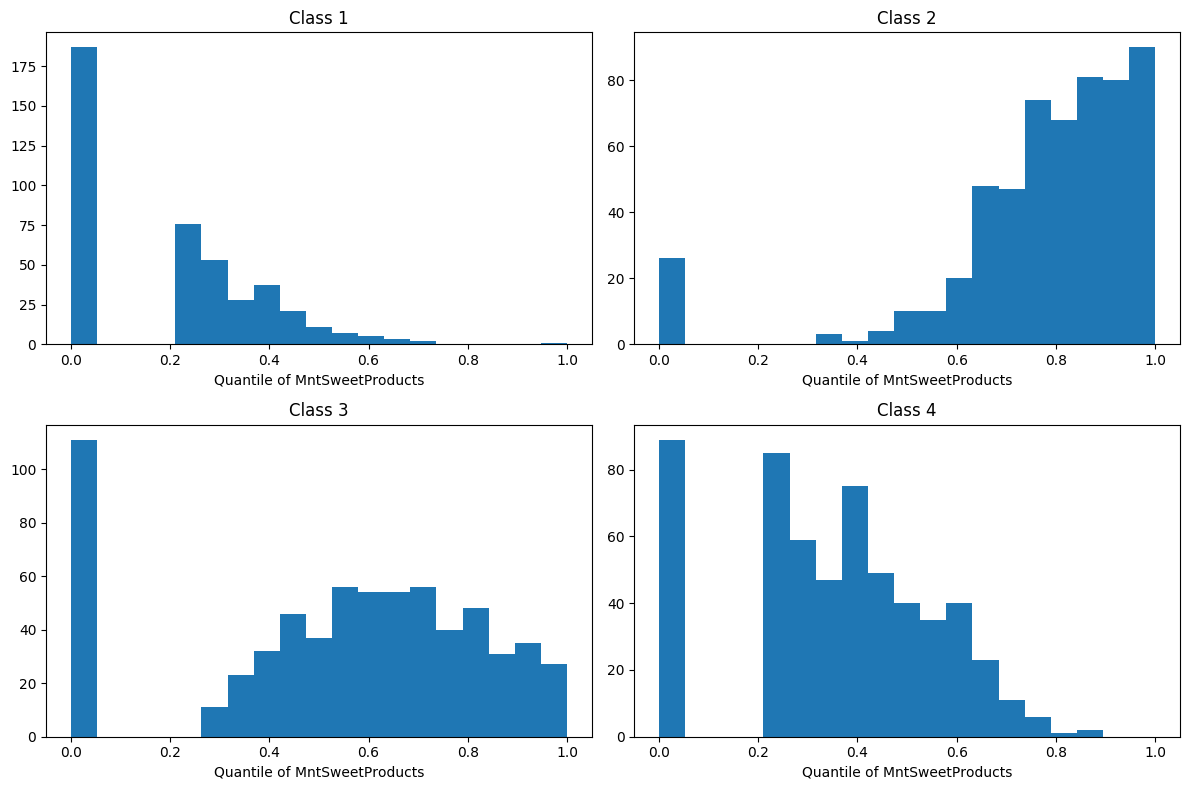

class 1 spent $4 on sweets, on average
class 2 spent $65 on sweets, on average
class 3 spent $33 on sweets, on average
class 4 spent $7 on sweets, on average
Plotting MntGoldProds
float64


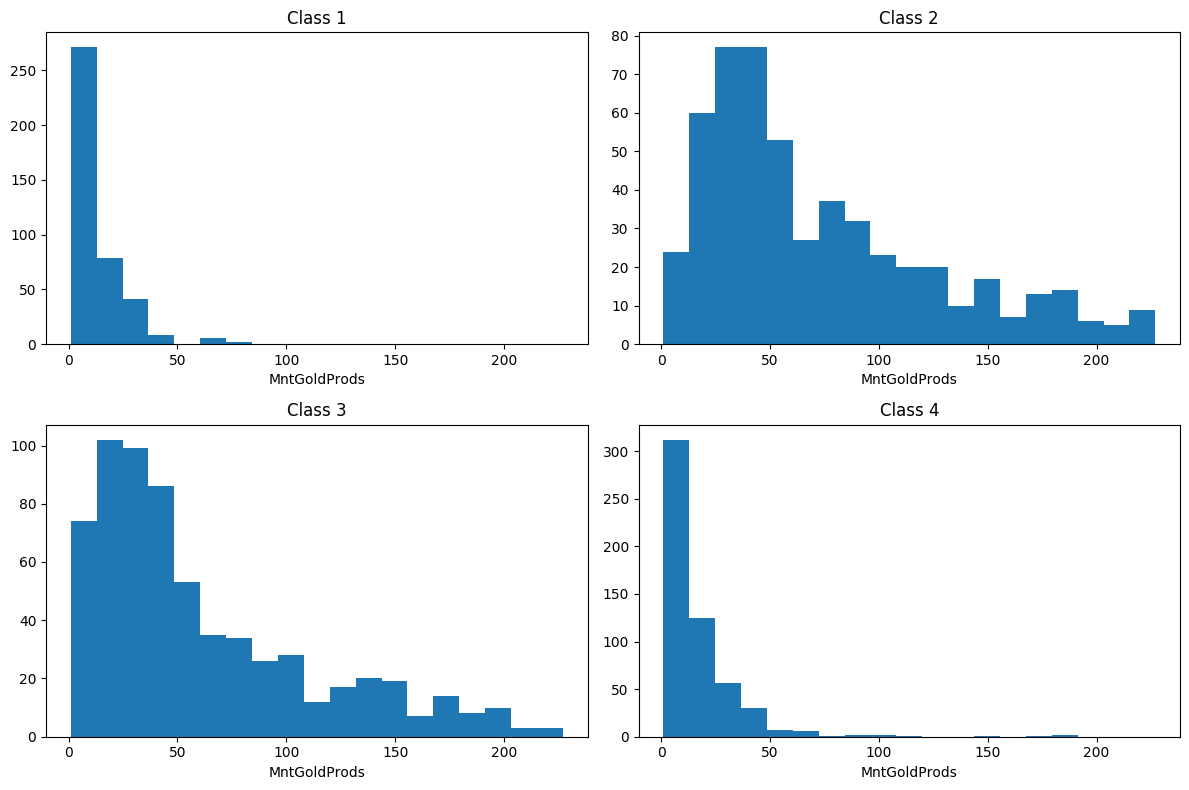

Plotting MntGoldProds
float64


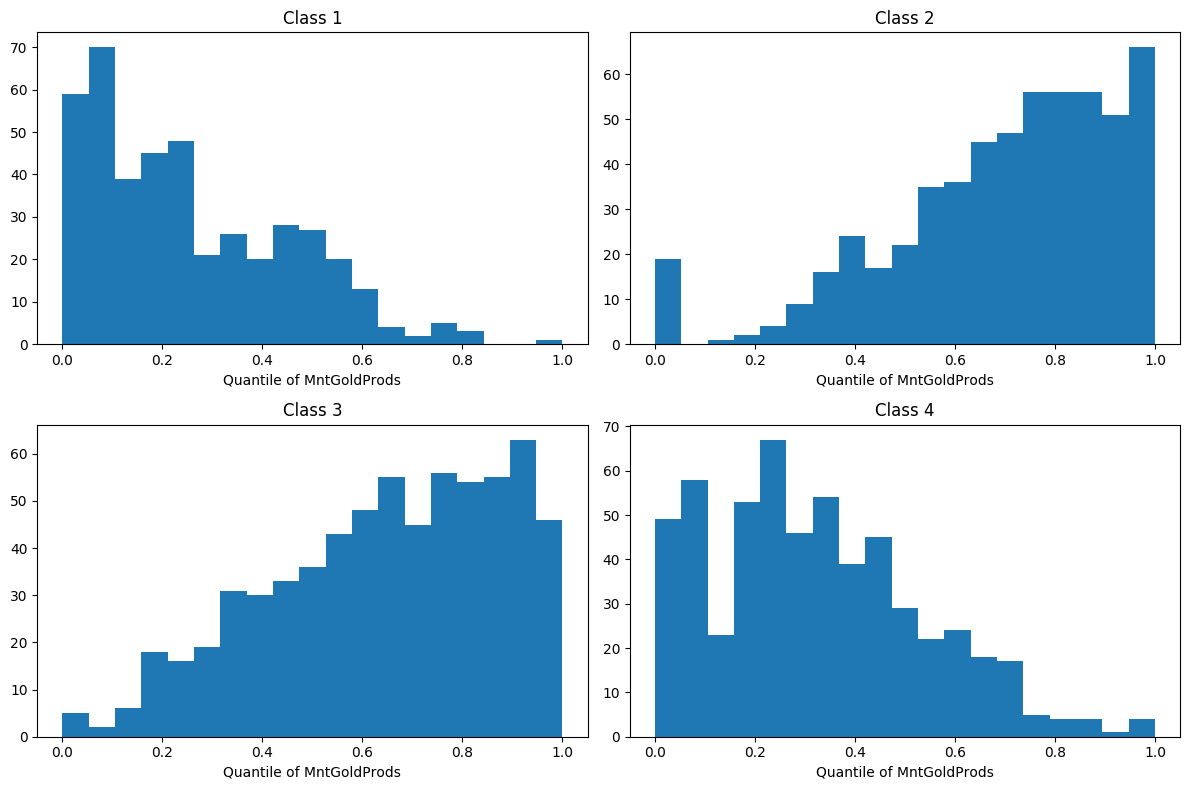

class 1 spent $12 on gold products, on average
class 2 spent $73 on gold products, on average
class 3 spent $61 on gold products, on average
class 4 spent $17 on gold products, on average
Plotting NumDealsPurchases
float64


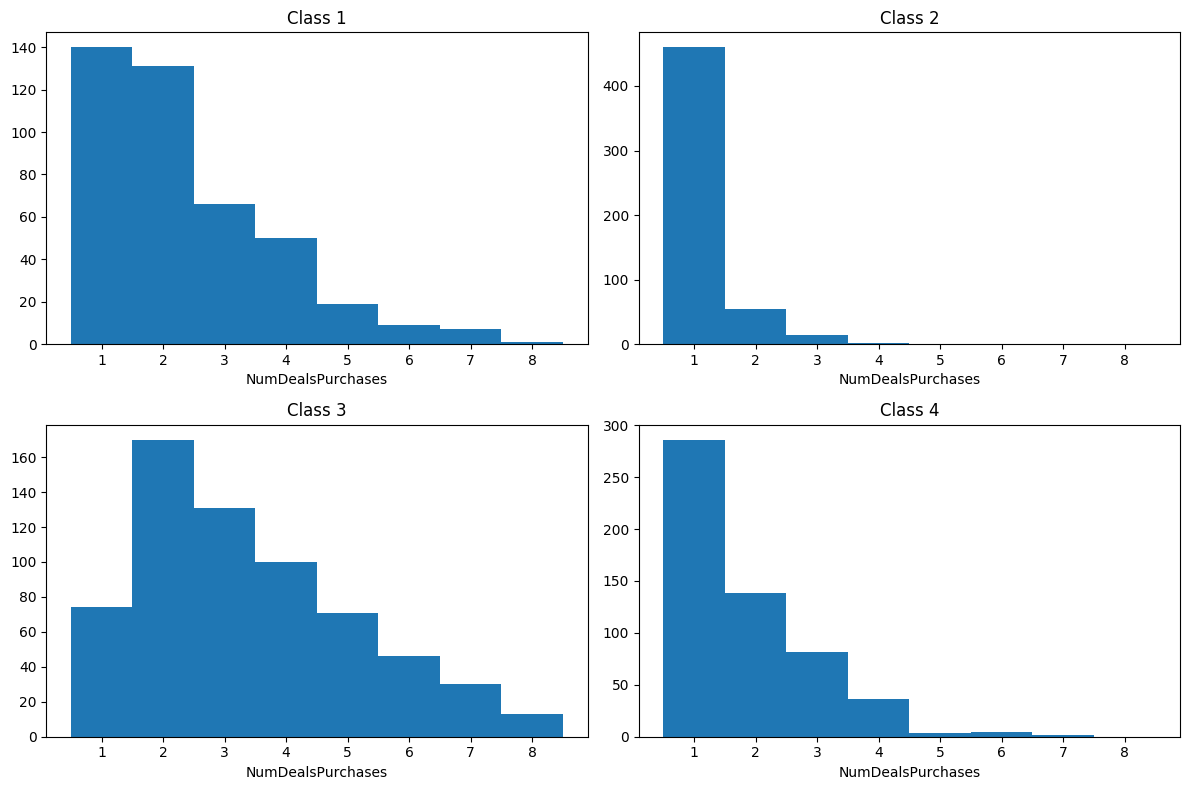

class 1 made 2 with discounts, on average
class 2 made 1 with discounts, on average
class 3 made 3 with discounts, on average
class 4 made 2 with discounts, on average
Plotting NumWebPurchases
float64


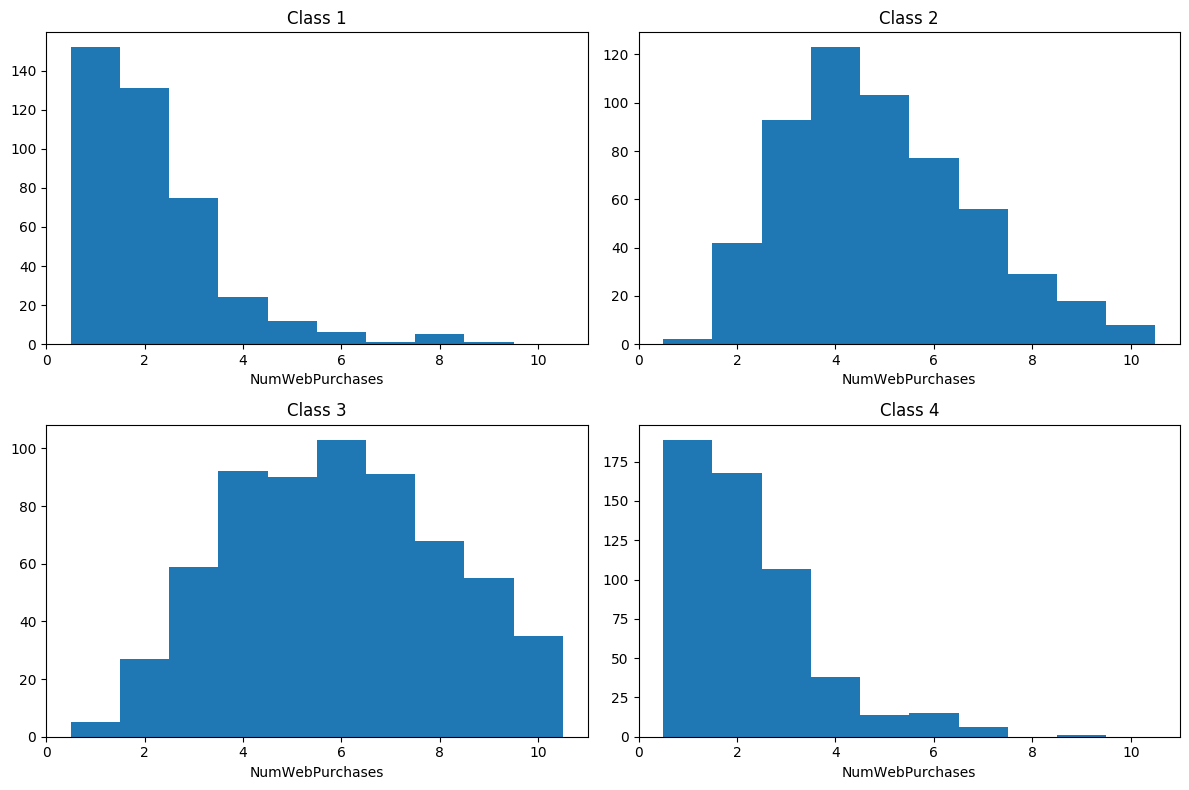

class 1 made 2 web purchases, on average
class 2 made 5 web purchases, on average
class 3 made 6 web purchases, on average
class 4 made 2 web purchases, on average
Plotting NumCatalogPurchases
float64


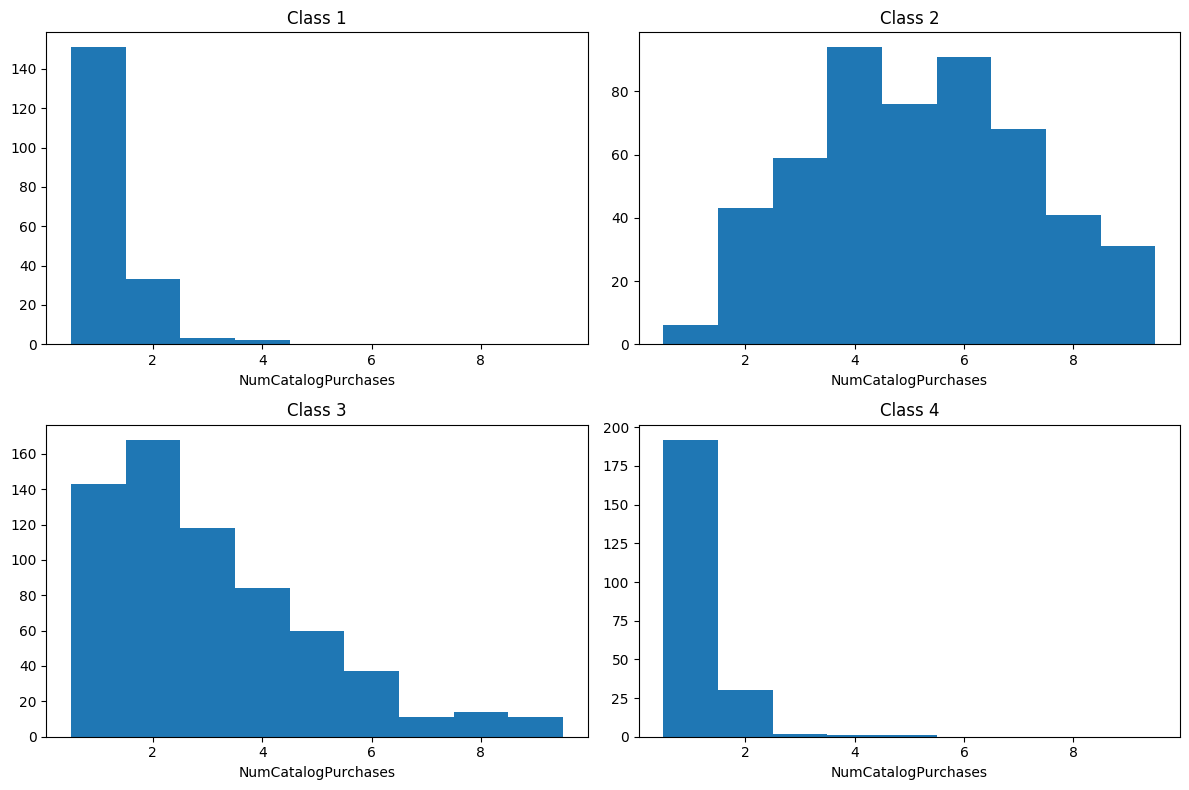

class 1 made 1 catalog purchases, on average
class 2 made 6 catalog purchases, on average
class 3 made 3 catalog purchases, on average
class 4 made 1 catalog purchases, on average
Plotting NumStorePurchases
float64


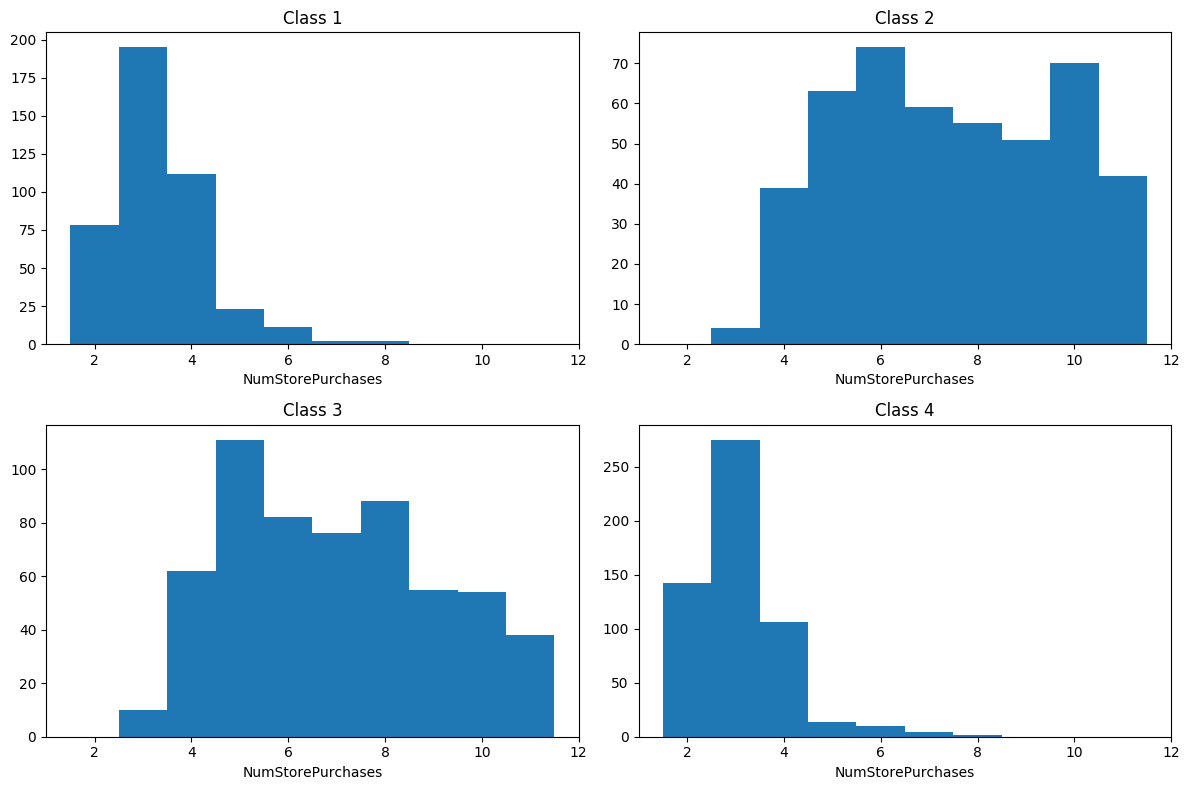

class 1 made 3 store purchases, on average
class 2 made 8 store purchases, on average
class 3 made 7 store purchases, on average
class 4 made 3 store purchases, on average
Plotting NumWebVisitsMonth
float64


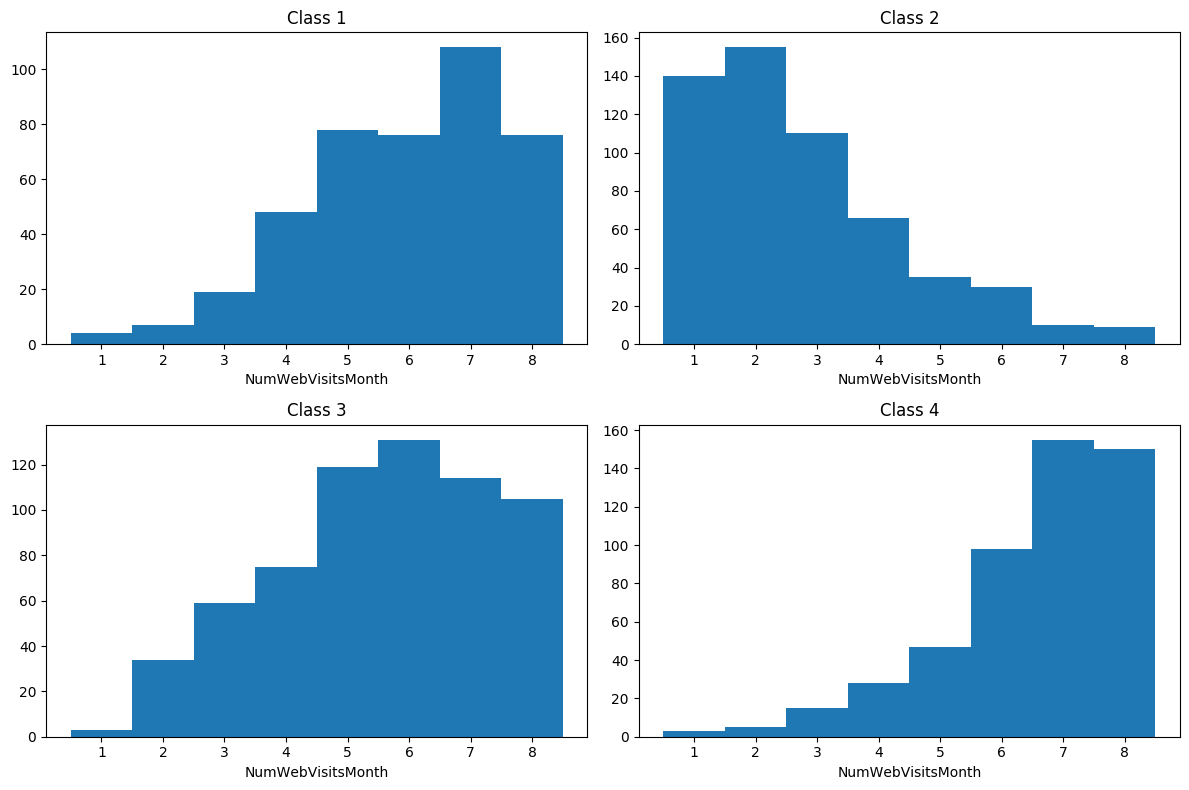

class 1 made 6 web vists in the last month, on average
class 2 made 3 web vists in the last month, on average
class 3 made 6 web vists in the last month, on average
class 4 made 7 web vists in the last month, on average


In [28]:
# the first thing is to note the differences in income.
print(column_names)
descriptors = {"Year_Birth": "was born in {}, on average",\
               "Income" : "earned ${:.0f}, on average",\
               'Kidhome' : "had {:.0f} kids, on average",\
               'Teenhome': "had {:.0f} teens, on average",\
               'Dt_Customer': "enrolled in {}, on average",\
               'Recency': "last purchased {:.0f} days ago, on average",\
               'MntWines': "spent ${:.0f} on wines, on average",\
               'MntFruits': "spent ${:.0f} on fruits, on average",\
               'MntMeatProducts': "spent ${:.0f} on meats, on average",\
               'MntFishProducts': "spent ${:.0f} on fish, on average",\
               'MntSweetProducts': "spent ${:.0f} on sweets, on average",\
               'MntGoldProds': "spent ${:.0f} on gold products, on average",\
               'NumDealsPurchases': "made {:.0f} with discounts, on average",\
               'NumWebPurchases': "made {:.0f} web purchases, on average",\
               'NumCatalogPurchases': "made {:.0f} catalog purchases, on average",\
               'NumStorePurchases': "made {:.0f} store purchases, on average",\
               'NumWebVisitsMonth': "made {:.0f} web vists in the last month, on average"}

y_labels = {"Year_Birth": "average year of birth",\
            "Income" : "average income in $",\
            'Kidhome' : "average number of kids at home",\
            'Teenhome': "haverage number of teenagers at home",\
            'Dt_Customer': "average year of enrollment",\
            'Recency': "average days since last purchase",\
            'MntWines': "average amount spent on wine in $",\
            'MntFruits': "average amount spent on fruits in $",\
            'MntMeatProducts': "average amount spent on meats in $",\
            'MntFishProducts': "average amount spent on fish in $",\
            'MntSweetProducts': "average amount spent on sweets in $",\
            'MntGoldProds': "average amount spent on gold products in $",\
            'NumDealsPurchases': "average number of discounted purchases",\
            'NumWebPurchases': "average number of web purchases",\
            'NumCatalogPurchases': "average number of catalog purchases",\
            'NumStorePurchases': "average number of store purchases",\
            'NumWebVisitsMonth': "average number of web visits a month"}

to_plot = []
for column_name in column_names:
    to_plot.append(analyze_column(column_name, column_names, data_arrays, data_arrays_quantiled, pred, descriptors))

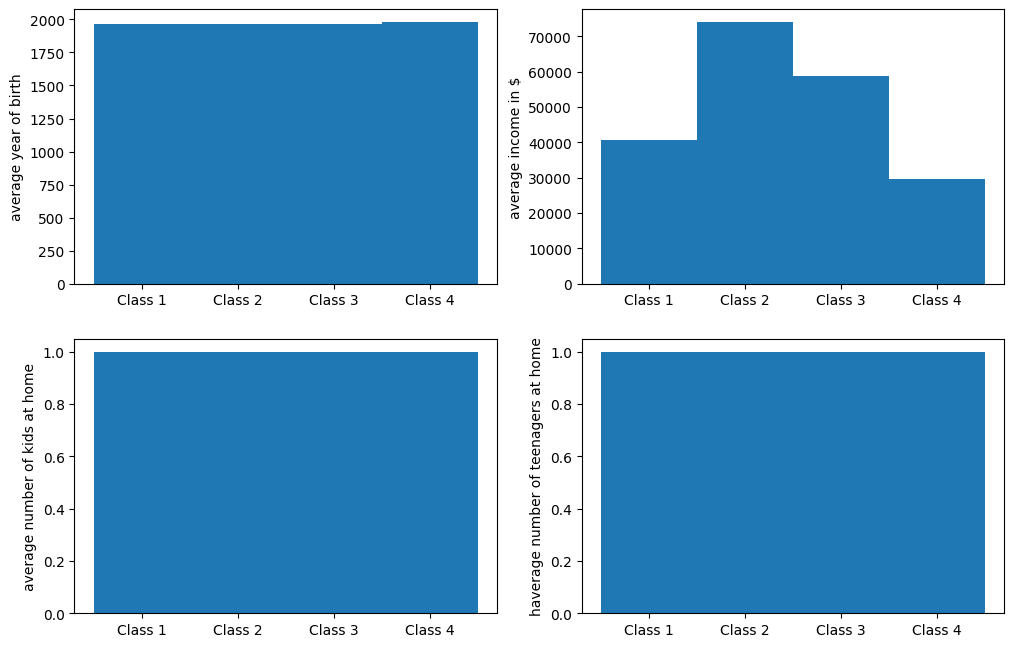

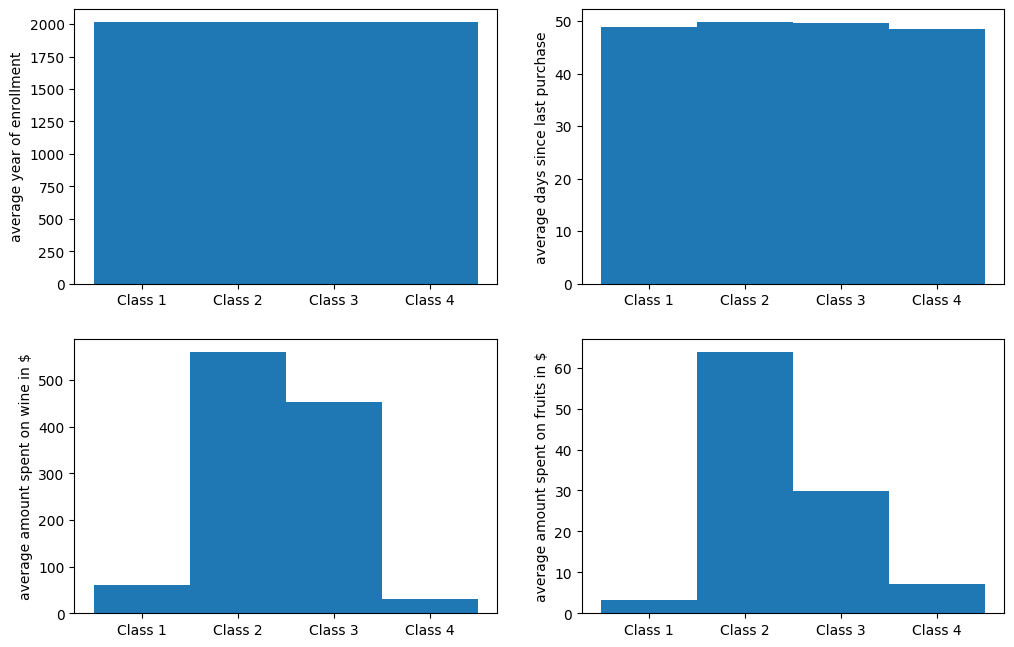

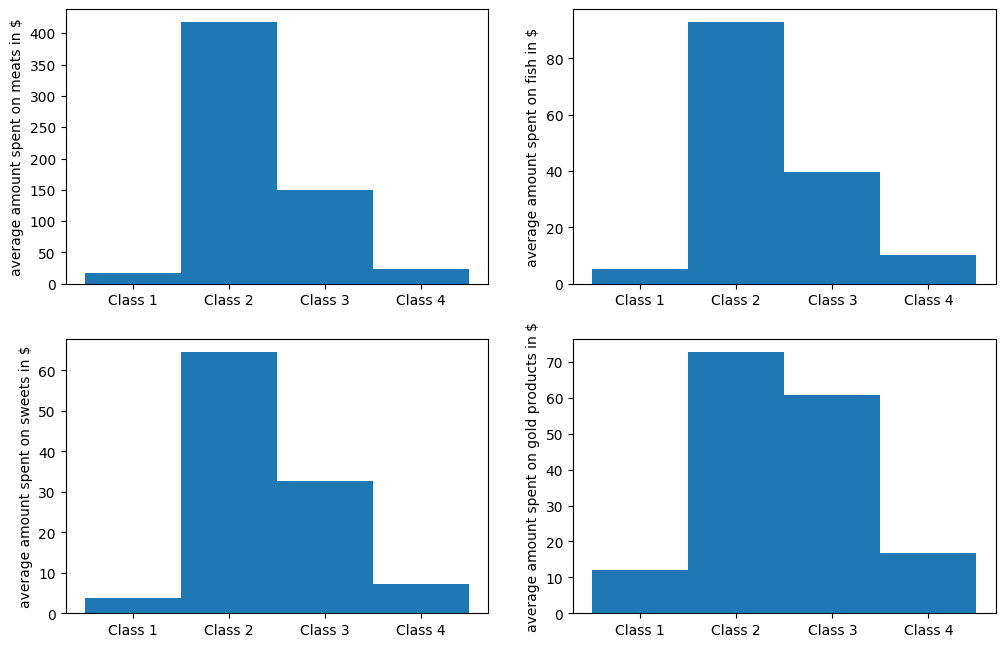

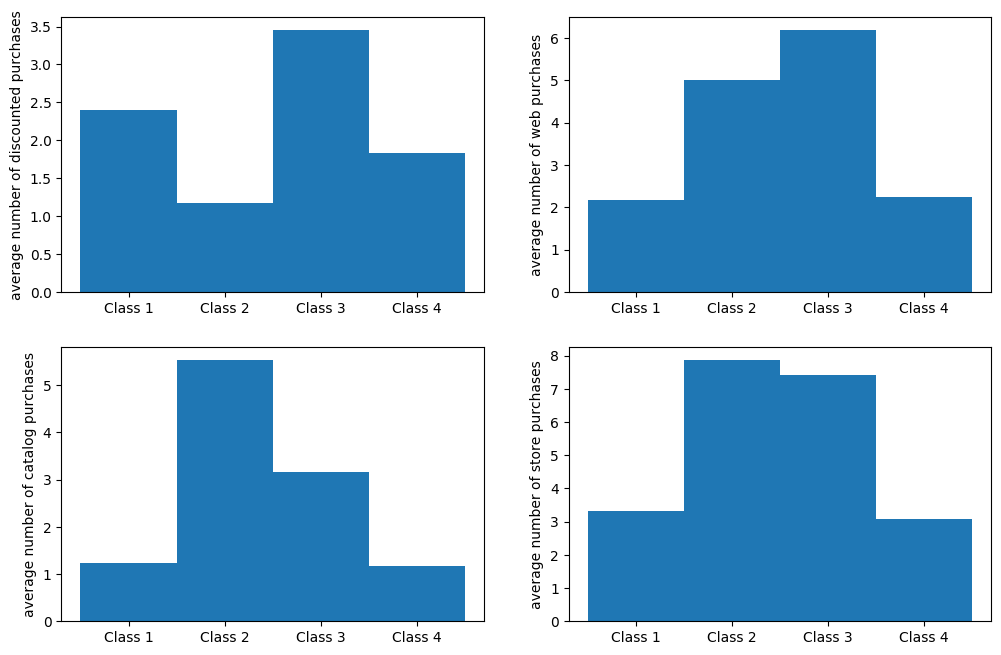

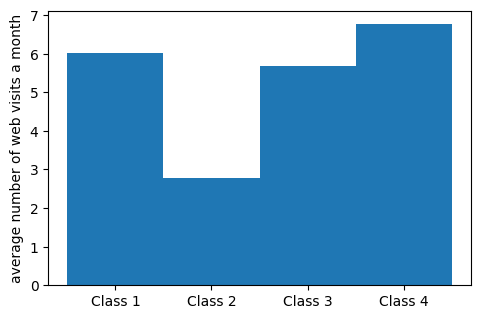

In [49]:
#make a series of bar plots for each column and class:
x = [1, 2, 3, 4]
for i, (column_name, el) in enumerate(zip(column_names, to_plot)):
    plt.subplot(220+(i%4) + 1)
    if (column_name == "Year_Birth" or column_name == "Dt_Customer"):
        el = [int(str(mip)) for mip in el]
    plt.bar(x, el, width=1.0, tick_label = ["Class 1", "Class 2", "Class 3", "Class 4"])
    plt.ylabel(y_labels[column_name])
    if (i%4) == 3: plt.show()


In [ ]:
column_names